# Learning the Inverse Discrete Fourier Transform

The Inverse Discrete Fourier Transform (IDFT) is used for reconstructing images acquired in k-space (Fourier domain). In this tutorial, we will show that the IDFT is equivalent to the logistic regression classifier and the logistic regression parameters (i.e. the IDFT coefficients) can be learned.


The goals of this tutorial are:
  - Illustrate how to do the IDFT and the logistic regression classifier are equivalents.
  - Illustrate that we can learn the IDFT coefficients.
  

## IDFT

The IDFT is given by:

$$x[n] = \frac{1}{N}\sum_{m=0}^{N-1}X[m]W^ {-mn}$$

where:

$$W = e^{-j2\pi /N} = cos(-2\pi/N) + jsin(-2\pi/N)$$

Therefore, we can write the system:

$$
\begin{bmatrix}
    x[0]  \\
    x[1] \\
    \vdots  \\
    x[n-1]
\end{bmatrix} =
\begin{bmatrix}
    W^0 & W^0 & W^0 & \dots  & W^0 \\
    W^0 & W^{-1} & W^{-2} & \dots  & W^{-(N-1)} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    W^0 & W^{-(N-1)} & W^{-2(N-1)} & \dots  & W^{-(N-1)^2}
\end{bmatrix}
\begin{bmatrix}
    X[0]  \\
    X[1] \\
    \vdots  \\
    X[n-1]
\end{bmatrix}/N
$$

This formulation is similar to a 1-layer neural network (logistic classifier). We will learn the Fourier coefficients using the training procedure in this tutorial.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4) 
import matplotlib.pylab as plt
import numpy as np
import os

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import sys

MY_UTILS_PATH = '../Modules/'
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils 
np.random.seed(302)

/home/roberto/Documents/virtualenv/venv03/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading 1D Signals

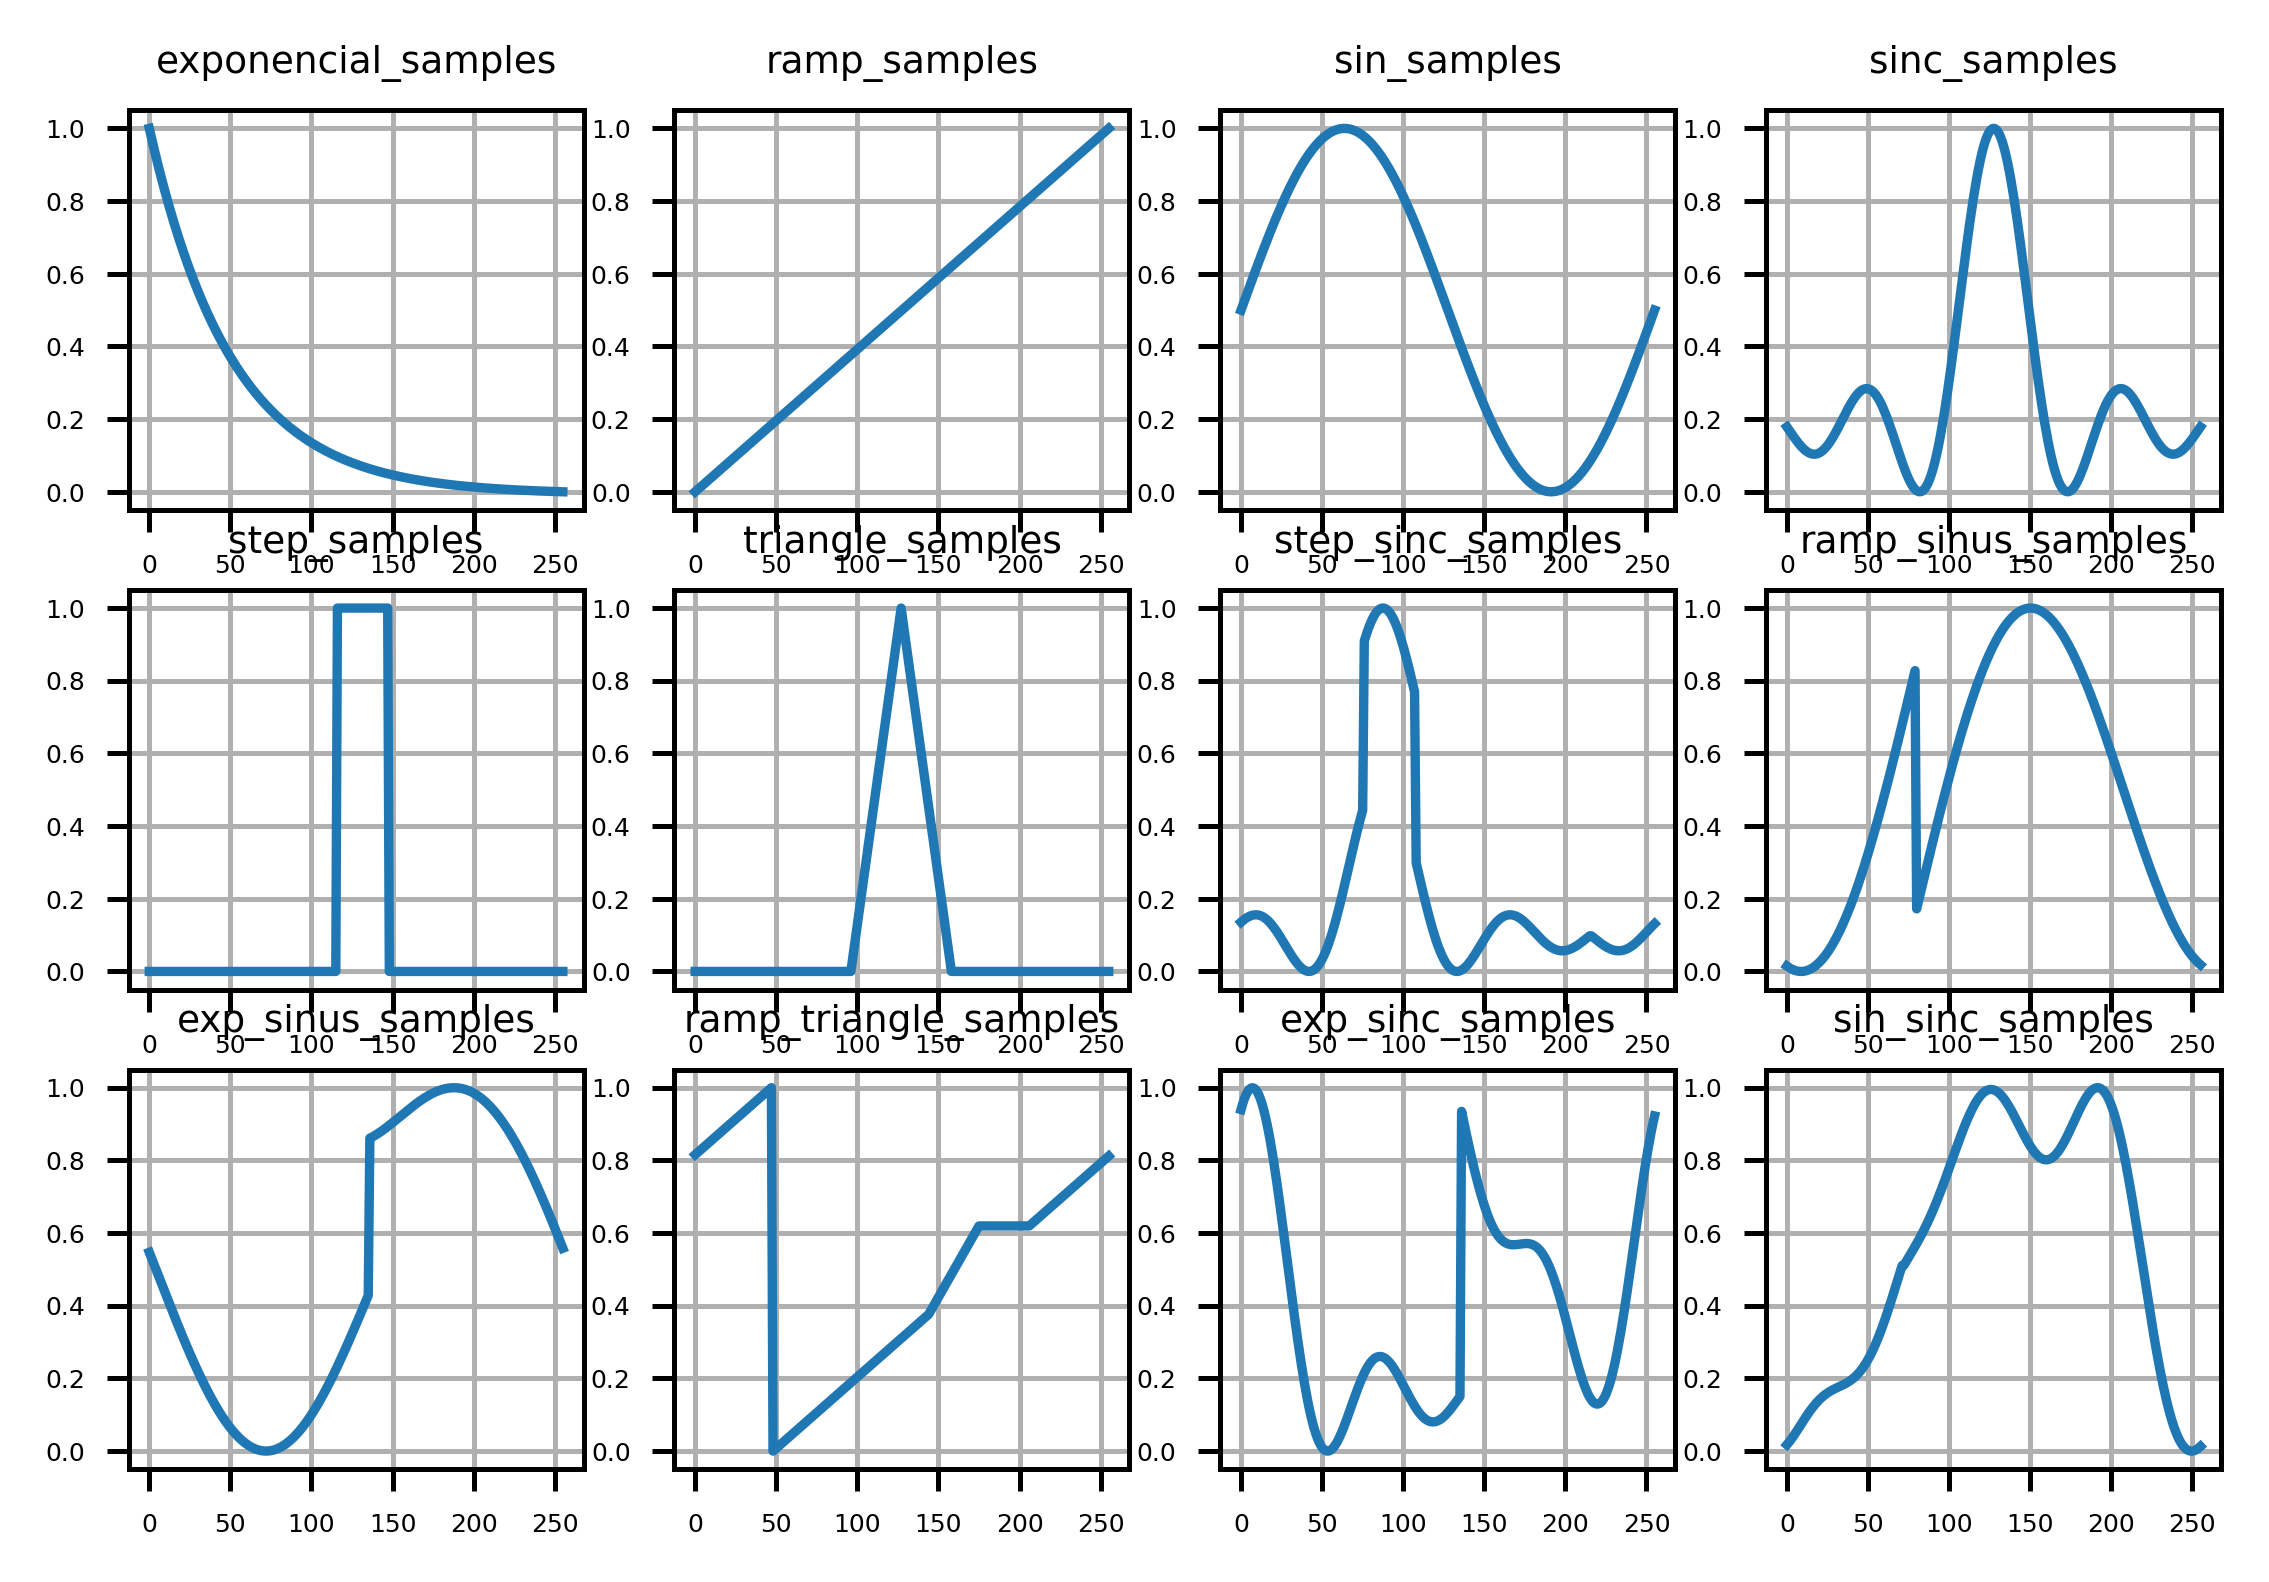

(360, 256)


In [2]:
signals_list = ["exponencial_samples.npy","ramp_samples.npy",\
                "sin_samples.npy","sinc_samples.npy","step_samples.npy",\
                "triangle_samples.npy","step_sinc_samples.npy",\
                "ramp_sinus_samples.npy","exp_sinus_samples.npy",\
                "ramp_triangle_samples.npy","exp_sinc_samples.npy","sin_sinc_samples.npy"]

signals_folder = "../Data"

shifts = 30
signals = np.zeros((len(signals_list)*shifts,256), dtype = np.float64)

# Loading data
for (ii,signal_file) in enumerate(signals_list):
    signals[ii*shifts:(ii+1)*shifts,:] = np.load(os.path.join(signals_folder,signal_file))
    

#Normalizing data between 0 and 1    
signals = (signals-signals.min(axis=1,keepdims = True))/\
          (signals.max(axis=1,keepdims = True)- signals.min(axis=1,keepdims = True))

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(signals[counter*shifts])
        col.grid()
        col.set_title(signals_list[counter].split(".")[0], fontsize = 6)
        counter+=1
plt.show()

print signals.shape

## Computing the Discrete Fourier Transform

In [3]:
fft_signals = np.fft.fft(signals)

#Shuffling samples
indexes = np.arange(signals.shape[0],dtype = int)
np.random.shuffle(indexes)
signals = signals[indexes]
fft_signals = fft_signals[indexes]

# Splitting into train and test sets
test_split = int(0.2*signals.shape[0])
signals_train = signals[:-test_split]
signals_test = signals[-test_split:]
fft_signals_train = fft_signals[:-test_split]
fft_signals_test = fft_signals[-test_split:]

#Splitting real and imaginary part and normalizing by the absolute value
# Train set
max_term = np.maximum(np.abs(fft_signals_train.real).max(),\
           np.abs(fft_signals_train.imag).max())           
fft_signals_train_split = np.zeros((fft_signals_train.shape[0],2*fft_signals_train.shape[1]))
fft_signals_train_split[:,:fft_signals_train.shape[1]] = fft_signals_train.real/max_term
fft_signals_train_split[:,fft_signals_train.shape[1]:] = fft_signals_train.imag/max_term

# Test
fft_signals_test_split = np.zeros((fft_signals_test.shape[0],2*fft_signals_test.shape[1]))
fft_signals_test_split[:,:fft_signals_test.shape[1]] = fft_signals_test.real/max_term
fft_signals_test_split[:,fft_signals_test.shape[1]:] = fft_signals_test.imag/max_term

## Defining the Logistic Regression Classifier to Compute the IDFT

In [4]:
def inverse_ft_model(learning_rate = 1e-3, learning_decay = 1e-8):
    inputs = Input(shape=(512,))
    out1 = Dense(256, activation='linear')(inputs)
    model = Model(inputs=inputs, outputs=out1)
    opt = Adam(lr=learning_rate, decay = learning_decay)
    model.compile(optimizer= opt,loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

## Training the Model

In [5]:
# Early stopping callback to shut down training after 
# 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='mean_squared_error',
                                        patience=10, 
                                        verbose=1, mode='min')
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint('inverse_ft.hdf5', mode = 'min', monitor='mean_squared_error'
                            ,verbose=0, save_best_only=True, save_weights_only = True)

model = inverse_ft_model(learning_rate = 1e-2, learning_decay = 1e-7) 
print signals_train.shape
print signals_train.dtype
print fft_signals_train_split.shape
print fft_signals_train_split.dtype
hist = model.fit(fft_signals_train_split,signals_train,epochs=5000,
                 batch_size=128,verbose=1,
                 validation_split=0.25,
                 shuffle = True,
                 callbacks=[checkpoint,earlyStopping])   

(288, 256)
float64
(288, 512)
float64
Train on 216 samples, validate on 72 samples
Epoch 1/5000
216/216 [==============================] - 0s 1ms/step - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2324 - val_mean_squared_error: 0.2324
Epoch 2/5000
216/216 [==============================] - 0s 546us/step - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2022 - val_mean_squared_error: 0.2022
Epoch 3/5000
216/216 [==============================] - 0s 347us/step - loss: 0.1805 - mean_squared_error: 0.1805 - val_loss: 0.1752 - val_mean_squared_error: 0.1752
Epoch 4/5000
216/216 [==============================] - 0s 451us/step - loss: 0.1549 - mean_squared_error: 0.1549 - val_loss: 0.1507 - val_mean_squared_error: 0.1507
Epoch 5/5000
216/216 [==============================] - 0s 404us/step - loss: 0.1322 - mean_squared_error: 0.1322 - val_loss: 0.1287 - val_mean_squared_error: 0.1287
Epoch 6/5000
216/216 [==============================] - 0s 324us/step - loss: 0.1123 - me

Epoch 50/5000
216/216 [==============================] - 0s 115us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 51/5000
216/216 [==============================] - 0s 165us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 52/5000
216/216 [==============================] - 0s 96us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 53/5000
216/216 [==============================] - 0s 107us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 54/5000
216/216 [==============================] - 0s 128us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 55/5000
216/216 [==============================] - 0s 91us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0053 - val_mean_squared_error: 0.0053


216/216 [==============================] - 0s 120us/step - loss: 9.7309e-04 - mean_squared_error: 9.7309e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 100/5000
216/216 [==============================] - 0s 116us/step - loss: 9.4634e-04 - mean_squared_error: 9.4634e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 101/5000
216/216 [==============================] - 0s 122us/step - loss: 9.2134e-04 - mean_squared_error: 9.2134e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 102/5000
216/216 [==============================] - 0s 107us/step - loss: 8.9830e-04 - mean_squared_error: 8.9830e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 103/5000
216/216 [==============================] - 0s 102us/step - loss: 8.7443e-04 - mean_squared_error: 8.7443e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 104/5000
216/216 [==============================] - 0s 114us/step - loss: 8.5041e-04 - mean_squared_error: 8.5041e-04 - val_loss:

Epoch 146/5000
216/216 [==============================] - 0s 127us/step - loss: 3.1004e-04 - mean_squared_error: 3.1004e-04 - val_loss: 9.7878e-04 - val_mean_squared_error: 9.7878e-04
Epoch 147/5000
216/216 [==============================] - 0s 132us/step - loss: 3.0332e-04 - mean_squared_error: 3.0332e-04 - val_loss: 9.6429e-04 - val_mean_squared_error: 9.6429e-04
Epoch 148/5000
216/216 [==============================] - 0s 140us/step - loss: 2.9712e-04 - mean_squared_error: 2.9712e-04 - val_loss: 9.5004e-04 - val_mean_squared_error: 9.5004e-04
Epoch 149/5000
216/216 [==============================] - 0s 143us/step - loss: 2.9065e-04 - mean_squared_error: 2.9065e-04 - val_loss: 9.3654e-04 - val_mean_squared_error: 9.3654e-04
Epoch 150/5000
216/216 [==============================] - 0s 131us/step - loss: 2.8449e-04 - mean_squared_error: 2.8449e-04 - val_loss: 9.2383e-04 - val_mean_squared_error: 9.2383e-04
Epoch 151/5000
216/216 [==============================] - 0s 146us/step - loss: 

216/216 [==============================] - 0s 971us/step - loss: 1.3192e-04 - mean_squared_error: 1.3192e-04 - val_loss: 5.5571e-04 - val_mean_squared_error: 5.5571e-04
Epoch 191/5000
216/216 [==============================] - 0s 487us/step - loss: 1.2970e-04 - mean_squared_error: 1.2970e-04 - val_loss: 5.4938e-04 - val_mean_squared_error: 5.4938e-04
Epoch 192/5000
216/216 [==============================] - 0s 640us/step - loss: 1.2745e-04 - mean_squared_error: 1.2745e-04 - val_loss: 5.4312e-04 - val_mean_squared_error: 5.4312e-04
Epoch 193/5000
216/216 [==============================] - 0s 487us/step - loss: 1.2541e-04 - mean_squared_error: 1.2541e-04 - val_loss: 5.3674e-04 - val_mean_squared_error: 5.3674e-04
Epoch 194/5000
216/216 [==============================] - 0s 594us/step - loss: 1.2328e-04 - mean_squared_error: 1.2328e-04 - val_loss: 5.3069e-04 - val_mean_squared_error: 5.3069e-04
Epoch 195/5000
216/216 [==============================] - 0s 684us/step - loss: 1.2122e-04 - me

216/216 [==============================] - 0s 101us/step - loss: 6.7303e-05 - mean_squared_error: 6.7303e-05 - val_loss: 3.6877e-04 - val_mean_squared_error: 3.6877e-04
Epoch 235/5000
216/216 [==============================] - 0s 112us/step - loss: 6.6347e-05 - mean_squared_error: 6.6347e-05 - val_loss: 3.6549e-04 - val_mean_squared_error: 3.6549e-04
Epoch 236/5000
216/216 [==============================] - 0s 109us/step - loss: 6.5449e-05 - mean_squared_error: 6.5449e-05 - val_loss: 3.6254e-04 - val_mean_squared_error: 3.6254e-04
Epoch 237/5000
216/216 [==============================] - 0s 126us/step - loss: 6.4590e-05 - mean_squared_error: 6.4590e-05 - val_loss: 3.5983e-04 - val_mean_squared_error: 3.5983e-04
Epoch 238/5000
216/216 [==============================] - 0s 96us/step - loss: 6.3776e-05 - mean_squared_error: 6.3776e-05 - val_loss: 3.5704e-04 - val_mean_squared_error: 3.5704e-04
Epoch 239/5000
216/216 [==============================] - 0s 124us/step - loss: 6.2925e-05 - mea

216/216 [==============================] - 0s 129us/step - loss: 3.9468e-05 - mean_squared_error: 3.9468e-05 - val_loss: 2.7181e-04 - val_mean_squared_error: 2.7181e-04
Epoch 279/5000
216/216 [==============================] - 0s 146us/step - loss: 3.9051e-05 - mean_squared_error: 3.9051e-05 - val_loss: 2.7010e-04 - val_mean_squared_error: 2.7010e-04
Epoch 280/5000
216/216 [==============================] - 0s 105us/step - loss: 3.8642e-05 - mean_squared_error: 3.8642e-05 - val_loss: 2.6843e-04 - val_mean_squared_error: 2.6843e-04
Epoch 281/5000
216/216 [==============================] - 0s 112us/step - loss: 3.8211e-05 - mean_squared_error: 3.8211e-05 - val_loss: 2.6667e-04 - val_mean_squared_error: 2.6667e-04
Epoch 282/5000
216/216 [==============================] - 0s 140us/step - loss: 3.7818e-05 - mean_squared_error: 3.7818e-05 - val_loss: 2.6505e-04 - val_mean_squared_error: 2.6505e-04
Epoch 283/5000
216/216 [==============================] - 0s 121us/step - loss: 3.7422e-05 - me

216/216 [==============================] - 0s 118us/step - loss: 2.5695e-05 - mean_squared_error: 2.5695e-05 - val_loss: 2.1081e-04 - val_mean_squared_error: 2.1081e-04
Epoch 323/5000
216/216 [==============================] - 0s 121us/step - loss: 2.5472e-05 - mean_squared_error: 2.5472e-05 - val_loss: 2.0970e-04 - val_mean_squared_error: 2.0970e-04
Epoch 324/5000
216/216 [==============================] - 0s 101us/step - loss: 2.5256e-05 - mean_squared_error: 2.5256e-05 - val_loss: 2.0865e-04 - val_mean_squared_error: 2.0865e-04
Epoch 325/5000
216/216 [==============================] - 0s 101us/step - loss: 2.5041e-05 - mean_squared_error: 2.5041e-05 - val_loss: 2.0763e-04 - val_mean_squared_error: 2.0763e-04
Epoch 326/5000
216/216 [==============================] - 0s 112us/step - loss: 2.4831e-05 - mean_squared_error: 2.4831e-05 - val_loss: 2.0657e-04 - val_mean_squared_error: 2.0657e-04
Epoch 327/5000
216/216 [==============================] - 0s 121us/step - loss: 2.4601e-05 - me

216/216 [==============================] - 0s 135us/step - loss: 1.8057e-05 - mean_squared_error: 1.8057e-05 - val_loss: 1.6879e-04 - val_mean_squared_error: 1.6879e-04
Epoch 367/5000
216/216 [==============================] - 0s 136us/step - loss: 1.7927e-05 - mean_squared_error: 1.7927e-05 - val_loss: 1.6791e-04 - val_mean_squared_error: 1.6791e-04
Epoch 368/5000
216/216 [==============================] - 0s 109us/step - loss: 1.7805e-05 - mean_squared_error: 1.7805e-05 - val_loss: 1.6715e-04 - val_mean_squared_error: 1.6715e-04
Epoch 369/5000
216/216 [==============================] - 0s 138us/step - loss: 1.7675e-05 - mean_squared_error: 1.7675e-05 - val_loss: 1.6636e-04 - val_mean_squared_error: 1.6636e-04
Epoch 370/5000
216/216 [==============================] - 0s 181us/step - loss: 1.7545e-05 - mean_squared_error: 1.7545e-05 - val_loss: 1.6577e-04 - val_mean_squared_error: 1.6577e-04
Epoch 371/5000
216/216 [==============================] - 0s 196us/step - loss: 1.7420e-05 - me

216/216 [==============================] - 0s 100us/step - loss: 1.3461e-05 - mean_squared_error: 1.3461e-05 - val_loss: 1.3974e-04 - val_mean_squared_error: 1.3974e-04
Epoch 411/5000
216/216 [==============================] - 0s 134us/step - loss: 1.3377e-05 - mean_squared_error: 1.3377e-05 - val_loss: 1.3922e-04 - val_mean_squared_error: 1.3922e-04
Epoch 412/5000
216/216 [==============================] - 0s 126us/step - loss: 1.3301e-05 - mean_squared_error: 1.3301e-05 - val_loss: 1.3869e-04 - val_mean_squared_error: 1.3869e-04
Epoch 413/5000
216/216 [==============================] - 0s 112us/step - loss: 1.3211e-05 - mean_squared_error: 1.3211e-05 - val_loss: 1.3816e-04 - val_mean_squared_error: 1.3816e-04
Epoch 414/5000
216/216 [==============================] - 0s 126us/step - loss: 1.3131e-05 - mean_squared_error: 1.3131e-05 - val_loss: 1.3764e-04 - val_mean_squared_error: 1.3764e-04
Epoch 415/5000
216/216 [==============================] - 0s 128us/step - loss: 1.3074e-05 - me

216/216 [==============================] - 0s 152us/step - loss: 1.0482e-05 - mean_squared_error: 1.0482e-05 - val_loss: 1.1858e-04 - val_mean_squared_error: 1.1858e-04
Epoch 455/5000
216/216 [==============================] - 0s 149us/step - loss: 1.0425e-05 - mean_squared_error: 1.0425e-05 - val_loss: 1.1811e-04 - val_mean_squared_error: 1.1811e-04
Epoch 456/5000
216/216 [==============================] - 0s 231us/step - loss: 1.0378e-05 - mean_squared_error: 1.0378e-05 - val_loss: 1.1764e-04 - val_mean_squared_error: 1.1764e-04
Epoch 457/5000
216/216 [==============================] - 0s 177us/step - loss: 1.0325e-05 - mean_squared_error: 1.0325e-05 - val_loss: 1.1715e-04 - val_mean_squared_error: 1.1715e-04
Epoch 458/5000
216/216 [==============================] - 0s 174us/step - loss: 1.0266e-05 - mean_squared_error: 1.0266e-05 - val_loss: 1.1667e-04 - val_mean_squared_error: 1.1667e-04
Epoch 459/5000
216/216 [==============================] - 0s 170us/step - loss: 1.0212e-05 - me

216/216 [==============================] - 0s 134us/step - loss: 8.4476e-06 - mean_squared_error: 8.4476e-06 - val_loss: 1.0254e-04 - val_mean_squared_error: 1.0254e-04
Epoch 499/5000
216/216 [==============================] - 0s 125us/step - loss: 8.4068e-06 - mean_squared_error: 8.4068e-06 - val_loss: 1.0218e-04 - val_mean_squared_error: 1.0218e-04
Epoch 500/5000
216/216 [==============================] - 0s 138us/step - loss: 8.3705e-06 - mean_squared_error: 8.3705e-06 - val_loss: 1.0185e-04 - val_mean_squared_error: 1.0185e-04
Epoch 501/5000
216/216 [==============================] - 0s 114us/step - loss: 8.3330e-06 - mean_squared_error: 8.3330e-06 - val_loss: 1.0147e-04 - val_mean_squared_error: 1.0147e-04
Epoch 502/5000
216/216 [==============================] - 0s 120us/step - loss: 8.2845e-06 - mean_squared_error: 8.2845e-06 - val_loss: 1.0109e-04 - val_mean_squared_error: 1.0109e-04
Epoch 503/5000
216/216 [==============================] - 0s 103us/step - loss: 8.2546e-06 - me

216/216 [==============================] - 0s 106us/step - loss: 6.9942e-06 - mean_squared_error: 6.9942e-06 - val_loss: 8.9446e-05 - val_mean_squared_error: 8.9446e-05
Epoch 543/5000
216/216 [==============================] - 0s 143us/step - loss: 6.9609e-06 - mean_squared_error: 6.9609e-06 - val_loss: 8.9201e-05 - val_mean_squared_error: 8.9201e-05
Epoch 544/5000
216/216 [==============================] - 0s 138us/step - loss: 6.9328e-06 - mean_squared_error: 6.9328e-06 - val_loss: 8.8961e-05 - val_mean_squared_error: 8.8961e-05
Epoch 545/5000
216/216 [==============================] - 0s 100us/step - loss: 6.9079e-06 - mean_squared_error: 6.9079e-06 - val_loss: 8.8724e-05 - val_mean_squared_error: 8.8724e-05
Epoch 546/5000
216/216 [==============================] - 0s 121us/step - loss: 6.8820e-06 - mean_squared_error: 6.8820e-06 - val_loss: 8.8469e-05 - val_mean_squared_error: 8.8469e-05
Epoch 547/5000
216/216 [==============================] - 0s 129us/step - loss: 6.8566e-06 - me

216/216 [==============================] - 0s 105us/step - loss: 5.9193e-06 - mean_squared_error: 5.9193e-06 - val_loss: 7.9850e-05 - val_mean_squared_error: 7.9850e-05
Epoch 587/5000
216/216 [==============================] - 0s 106us/step - loss: 5.8934e-06 - mean_squared_error: 5.8934e-06 - val_loss: 7.9618e-05 - val_mean_squared_error: 7.9618e-05
Epoch 588/5000
216/216 [==============================] - 0s 110us/step - loss: 5.8730e-06 - mean_squared_error: 5.8730e-06 - val_loss: 7.9387e-05 - val_mean_squared_error: 7.9387e-05
Epoch 589/5000
216/216 [==============================] - 0s 131us/step - loss: 5.8555e-06 - mean_squared_error: 5.8555e-06 - val_loss: 7.9141e-05 - val_mean_squared_error: 7.9141e-05
Epoch 590/5000
216/216 [==============================] - 0s 124us/step - loss: 5.8356e-06 - mean_squared_error: 5.8356e-06 - val_loss: 7.8860e-05 - val_mean_squared_error: 7.8860e-05
Epoch 591/5000
216/216 [==============================] - 0s 96us/step - loss: 5.8136e-06 - mea

216/216 [==============================] - 0s 123us/step - loss: 5.0946e-06 - mean_squared_error: 5.0946e-06 - val_loss: 7.1813e-05 - val_mean_squared_error: 7.1813e-05
Epoch 631/5000
216/216 [==============================] - 0s 122us/step - loss: 5.0782e-06 - mean_squared_error: 5.0782e-06 - val_loss: 7.1666e-05 - val_mean_squared_error: 7.1666e-05
Epoch 632/5000
216/216 [==============================] - 0s 122us/step - loss: 5.0643e-06 - mean_squared_error: 5.0643e-06 - val_loss: 7.1486e-05 - val_mean_squared_error: 7.1486e-05
Epoch 633/5000
216/216 [==============================] - 0s 117us/step - loss: 5.0479e-06 - mean_squared_error: 5.0479e-06 - val_loss: 7.1319e-05 - val_mean_squared_error: 7.1319e-05
Epoch 634/5000
216/216 [==============================] - 0s 144us/step - loss: 5.0320e-06 - mean_squared_error: 5.0320e-06 - val_loss: 7.1109e-05 - val_mean_squared_error: 7.1109e-05
Epoch 635/5000
216/216 [==============================] - 0s 114us/step - loss: 5.0137e-06 - me

216/216 [==============================] - 0s 137us/step - loss: 4.4596e-06 - mean_squared_error: 4.4596e-06 - val_loss: 6.5561e-05 - val_mean_squared_error: 6.5561e-05
Epoch 675/5000
216/216 [==============================] - 0s 125us/step - loss: 4.4477e-06 - mean_squared_error: 4.4477e-06 - val_loss: 6.5471e-05 - val_mean_squared_error: 6.5471e-05
Epoch 676/5000
216/216 [==============================] - 0s 126us/step - loss: 4.4318e-06 - mean_squared_error: 4.4318e-06 - val_loss: 6.5347e-05 - val_mean_squared_error: 6.5347e-05
Epoch 677/5000
216/216 [==============================] - 0s 134us/step - loss: 4.4250e-06 - mean_squared_error: 4.4250e-06 - val_loss: 6.5227e-05 - val_mean_squared_error: 6.5227e-05
Epoch 678/5000
216/216 [==============================] - 0s 122us/step - loss: 4.4083e-06 - mean_squared_error: 4.4083e-06 - val_loss: 6.5083e-05 - val_mean_squared_error: 6.5083e-05
Epoch 679/5000
216/216 [==============================] - 0s 143us/step - loss: 4.3955e-06 - me

216/216 [==============================] - 0s 121us/step - loss: 3.9528e-06 - mean_squared_error: 3.9528e-06 - val_loss: 6.0614e-05 - val_mean_squared_error: 6.0614e-05
Epoch 719/5000
216/216 [==============================] - 0s 125us/step - loss: 3.9397e-06 - mean_squared_error: 3.9397e-06 - val_loss: 6.0532e-05 - val_mean_squared_error: 6.0532e-05
Epoch 720/5000
216/216 [==============================] - 0s 133us/step - loss: 3.9288e-06 - mean_squared_error: 3.9288e-06 - val_loss: 6.0435e-05 - val_mean_squared_error: 6.0435e-05
Epoch 721/5000
216/216 [==============================] - 0s 106us/step - loss: 3.9202e-06 - mean_squared_error: 3.9202e-06 - val_loss: 6.0336e-05 - val_mean_squared_error: 6.0336e-05
Epoch 722/5000
216/216 [==============================] - 0s 132us/step - loss: 3.9121e-06 - mean_squared_error: 3.9121e-06 - val_loss: 6.0244e-05 - val_mean_squared_error: 6.0244e-05
Epoch 723/5000
216/216 [==============================] - 0s 102us/step - loss: 3.9016e-06 - me

216/216 [==============================] - 0s 109us/step - loss: 3.5435e-06 - mean_squared_error: 3.5435e-06 - val_loss: 5.6581e-05 - val_mean_squared_error: 5.6581e-05
Epoch 763/5000
216/216 [==============================] - 0s 109us/step - loss: 3.5328e-06 - mean_squared_error: 3.5328e-06 - val_loss: 5.6486e-05 - val_mean_squared_error: 5.6486e-05
Epoch 764/5000
216/216 [==============================] - 0s 105us/step - loss: 3.5238e-06 - mean_squared_error: 3.5238e-06 - val_loss: 5.6406e-05 - val_mean_squared_error: 5.6406e-05
Epoch 765/5000
216/216 [==============================] - 0s 106us/step - loss: 3.5179e-06 - mean_squared_error: 3.5179e-06 - val_loss: 5.6328e-05 - val_mean_squared_error: 5.6328e-05
Epoch 766/5000
216/216 [==============================] - 0s 106us/step - loss: 3.5083e-06 - mean_squared_error: 3.5083e-06 - val_loss: 5.6254e-05 - val_mean_squared_error: 5.6254e-05
Epoch 767/5000
216/216 [==============================] - 0s 204us/step - loss: 3.4995e-06 - me

216/216 [==============================] - 0s 118us/step - loss: 3.2074e-06 - mean_squared_error: 3.2074e-06 - val_loss: 5.3390e-05 - val_mean_squared_error: 5.3390e-05
Epoch 807/5000
216/216 [==============================] - 0s 120us/step - loss: 3.1993e-06 - mean_squared_error: 3.1993e-06 - val_loss: 5.3308e-05 - val_mean_squared_error: 5.3308e-05
Epoch 808/5000
216/216 [==============================] - 0s 108us/step - loss: 3.1925e-06 - mean_squared_error: 3.1925e-06 - val_loss: 5.3221e-05 - val_mean_squared_error: 5.3221e-05
Epoch 809/5000
216/216 [==============================] - 0s 132us/step - loss: 3.1822e-06 - mean_squared_error: 3.1822e-06 - val_loss: 5.3131e-05 - val_mean_squared_error: 5.3131e-05
Epoch 810/5000
216/216 [==============================] - 0s 90us/step - loss: 3.1795e-06 - mean_squared_error: 3.1795e-06 - val_loss: 5.3070e-05 - val_mean_squared_error: 5.3070e-05
Epoch 811/5000
216/216 [==============================] - 0s 130us/step - loss: 3.1699e-06 - mea

216/216 [==============================] - 0s 104us/step - loss: 2.9234e-06 - mean_squared_error: 2.9234e-06 - val_loss: 5.0590e-05 - val_mean_squared_error: 5.0590e-05
Epoch 851/5000
216/216 [==============================] - 0s 144us/step - loss: 2.9187e-06 - mean_squared_error: 2.9187e-06 - val_loss: 5.0545e-05 - val_mean_squared_error: 5.0545e-05
Epoch 852/5000
216/216 [==============================] - 0s 124us/step - loss: 2.9111e-06 - mean_squared_error: 2.9111e-06 - val_loss: 5.0506e-05 - val_mean_squared_error: 5.0506e-05
Epoch 853/5000
216/216 [==============================] - 0s 120us/step - loss: 2.9061e-06 - mean_squared_error: 2.9061e-06 - val_loss: 5.0442e-05 - val_mean_squared_error: 5.0442e-05
Epoch 854/5000
216/216 [==============================] - 0s 137us/step - loss: 2.9005e-06 - mean_squared_error: 2.9005e-06 - val_loss: 5.0384e-05 - val_mean_squared_error: 5.0384e-05
Epoch 855/5000
216/216 [==============================] - 0s 120us/step - loss: 2.8961e-06 - me

216/216 [==============================] - 0s 118us/step - loss: 2.6875e-06 - mean_squared_error: 2.6875e-06 - val_loss: 4.8310e-05 - val_mean_squared_error: 4.8310e-05
Epoch 895/5000
216/216 [==============================] - 0s 141us/step - loss: 2.6784e-06 - mean_squared_error: 2.6784e-06 - val_loss: 4.8265e-05 - val_mean_squared_error: 4.8265e-05
Epoch 896/5000
216/216 [==============================] - 0s 126us/step - loss: 2.6728e-06 - mean_squared_error: 2.6728e-06 - val_loss: 4.8219e-05 - val_mean_squared_error: 4.8219e-05
Epoch 897/5000
216/216 [==============================] - 0s 96us/step - loss: 2.6685e-06 - mean_squared_error: 2.6685e-06 - val_loss: 4.8188e-05 - val_mean_squared_error: 4.8188e-05
Epoch 898/5000
216/216 [==============================] - 0s 104us/step - loss: 2.6625e-06 - mean_squared_error: 2.6625e-06 - val_loss: 4.8158e-05 - val_mean_squared_error: 4.8158e-05
Epoch 899/5000
216/216 [==============================] - 0s 182us/step - loss: 2.6621e-06 - mea

216/216 [==============================] - 0s 135us/step - loss: 2.4790e-06 - mean_squared_error: 2.4790e-06 - val_loss: 4.6374e-05 - val_mean_squared_error: 4.6374e-05
Epoch 939/5000
216/216 [==============================] - 0s 143us/step - loss: 2.4760e-06 - mean_squared_error: 2.4760e-06 - val_loss: 4.6353e-05 - val_mean_squared_error: 4.6353e-05
Epoch 940/5000
216/216 [==============================] - 0s 139us/step - loss: 2.4698e-06 - mean_squared_error: 2.4698e-06 - val_loss: 4.6313e-05 - val_mean_squared_error: 4.6313e-05
Epoch 941/5000
216/216 [==============================] - 0s 131us/step - loss: 2.4657e-06 - mean_squared_error: 2.4657e-06 - val_loss: 4.6275e-05 - val_mean_squared_error: 4.6275e-05
Epoch 942/5000
216/216 [==============================] - 0s 131us/step - loss: 2.4618e-06 - mean_squared_error: 2.4618e-06 - val_loss: 4.6254e-05 - val_mean_squared_error: 4.6254e-05
Epoch 943/5000
216/216 [==============================] - 0s 107us/step - loss: 2.4558e-06 - me

216/216 [==============================] - 0s 134us/step - loss: 2.3029e-06 - mean_squared_error: 2.3029e-06 - val_loss: 4.4757e-05 - val_mean_squared_error: 4.4757e-05
Epoch 983/5000
216/216 [==============================] - 0s 118us/step - loss: 2.2998e-06 - mean_squared_error: 2.2998e-06 - val_loss: 4.4696e-05 - val_mean_squared_error: 4.4696e-05
Epoch 984/5000
216/216 [==============================] - 0s 126us/step - loss: 2.2967e-06 - mean_squared_error: 2.2967e-06 - val_loss: 4.4640e-05 - val_mean_squared_error: 4.4640e-05
Epoch 985/5000
216/216 [==============================] - 0s 114us/step - loss: 2.2903e-06 - mean_squared_error: 2.2903e-06 - val_loss: 4.4609e-05 - val_mean_squared_error: 4.4609e-05
Epoch 986/5000
216/216 [==============================] - 0s 232us/step - loss: 2.2884e-06 - mean_squared_error: 2.2884e-06 - val_loss: 4.4581e-05 - val_mean_squared_error: 4.4581e-05
Epoch 987/5000
216/216 [==============================] - 0s 97us/step - loss: 2.2839e-06 - mea

216/216 [==============================] - 0s 117us/step - loss: 2.1457e-06 - mean_squared_error: 2.1457e-06 - val_loss: 4.3406e-05 - val_mean_squared_error: 4.3406e-05
Epoch 1027/5000
216/216 [==============================] - 0s 121us/step - loss: 2.1419e-06 - mean_squared_error: 2.1419e-06 - val_loss: 4.3358e-05 - val_mean_squared_error: 4.3358e-05
Epoch 1028/5000
216/216 [==============================] - 0s 128us/step - loss: 2.1385e-06 - mean_squared_error: 2.1385e-06 - val_loss: 4.3309e-05 - val_mean_squared_error: 4.3309e-05
Epoch 1029/5000
216/216 [==============================] - 0s 105us/step - loss: 2.1357e-06 - mean_squared_error: 2.1357e-06 - val_loss: 4.3282e-05 - val_mean_squared_error: 4.3282e-05
Epoch 1030/5000
216/216 [==============================] - 0s 105us/step - loss: 2.1349e-06 - mean_squared_error: 2.1349e-06 - val_loss: 4.3296e-05 - val_mean_squared_error: 4.3296e-05
Epoch 1031/5000
216/216 [==============================] - 0s 102us/step - loss: 2.1301e-06

216/216 [==============================] - 0s 121us/step - loss: 2.0056e-06 - mean_squared_error: 2.0056e-06 - val_loss: 4.2149e-05 - val_mean_squared_error: 4.2149e-05
Epoch 1071/5000
216/216 [==============================] - 0s 113us/step - loss: 2.0032e-06 - mean_squared_error: 2.0032e-06 - val_loss: 4.2103e-05 - val_mean_squared_error: 4.2103e-05
Epoch 1072/5000
216/216 [==============================] - 0s 131us/step - loss: 2.0019e-06 - mean_squared_error: 2.0019e-06 - val_loss: 4.2079e-05 - val_mean_squared_error: 4.2079e-05
Epoch 1073/5000
216/216 [==============================] - 0s 115us/step - loss: 1.9981e-06 - mean_squared_error: 1.9981e-06 - val_loss: 4.2072e-05 - val_mean_squared_error: 4.2072e-05
Epoch 1074/5000
216/216 [==============================] - 0s 112us/step - loss: 1.9941e-06 - mean_squared_error: 1.9941e-06 - val_loss: 4.2062e-05 - val_mean_squared_error: 4.2062e-05
Epoch 1075/5000
216/216 [==============================] - 0s 95us/step - loss: 1.9922e-06 

216/216 [==============================] - 0s 110us/step - loss: 1.8817e-06 - mean_squared_error: 1.8817e-06 - val_loss: 4.1127e-05 - val_mean_squared_error: 4.1127e-05
Epoch 1115/5000
216/216 [==============================] - 0s 121us/step - loss: 1.8803e-06 - mean_squared_error: 1.8803e-06 - val_loss: 4.1072e-05 - val_mean_squared_error: 4.1072e-05
Epoch 1116/5000
216/216 [==============================] - 0s 132us/step - loss: 1.8772e-06 - mean_squared_error: 1.8772e-06 - val_loss: 4.1043e-05 - val_mean_squared_error: 4.1043e-05
Epoch 1117/5000
216/216 [==============================] - 0s 103us/step - loss: 1.8755e-06 - mean_squared_error: 1.8755e-06 - val_loss: 4.1016e-05 - val_mean_squared_error: 4.1016e-05
Epoch 1118/5000
216/216 [==============================] - 0s 106us/step - loss: 1.8712e-06 - mean_squared_error: 1.8712e-06 - val_loss: 4.0994e-05 - val_mean_squared_error: 4.0994e-05
Epoch 1119/5000
216/216 [==============================] - 0s 106us/step - loss: 1.8702e-06

216/216 [==============================] - 0s 132us/step - loss: 1.7679e-06 - mean_squared_error: 1.7679e-06 - val_loss: 4.0178e-05 - val_mean_squared_error: 4.0178e-05
Epoch 1159/5000
216/216 [==============================] - 0s 60us/step - loss: 1.7693e-06 - mean_squared_error: 1.7693e-06 - val_loss: 4.0147e-05 - val_mean_squared_error: 4.0147e-05
Epoch 1160/5000
216/216 [==============================] - 0s 137us/step - loss: 1.7662e-06 - mean_squared_error: 1.7662e-06 - val_loss: 4.0121e-05 - val_mean_squared_error: 4.0121e-05
Epoch 1161/5000
216/216 [==============================] - 0s 149us/step - loss: 1.7656e-06 - mean_squared_error: 1.7656e-06 - val_loss: 4.0091e-05 - val_mean_squared_error: 4.0091e-05
Epoch 1162/5000
216/216 [==============================] - 0s 122us/step - loss: 1.7590e-06 - mean_squared_error: 1.7590e-06 - val_loss: 4.0064e-05 - val_mean_squared_error: 4.0064e-05
Epoch 1163/5000
216/216 [==============================] - 0s 57us/step - loss: 1.7604e-06 -

216/216 [==============================] - 0s 449us/step - loss: 1.6700e-06 - mean_squared_error: 1.6700e-06 - val_loss: 3.9286e-05 - val_mean_squared_error: 3.9286e-05
Epoch 1203/5000
216/216 [==============================] - 0s 453us/step - loss: 1.6677e-06 - mean_squared_error: 1.6677e-06 - val_loss: 3.9277e-05 - val_mean_squared_error: 3.9277e-05
Epoch 1204/5000
216/216 [==============================] - 0s 623us/step - loss: 1.6663e-06 - mean_squared_error: 1.6663e-06 - val_loss: 3.9270e-05 - val_mean_squared_error: 3.9270e-05
Epoch 1205/5000
216/216 [==============================] - 0s 633us/step - loss: 1.6622e-06 - mean_squared_error: 1.6622e-06 - val_loss: 3.9240e-05 - val_mean_squared_error: 3.9240e-05
Epoch 1206/5000
216/216 [==============================] - 0s 915us/step - loss: 1.6609e-06 - mean_squared_error: 1.6609e-06 - val_loss: 3.9215e-05 - val_mean_squared_error: 3.9215e-05
Epoch 1207/5000
216/216 [==============================] - 0s 430us/step - loss: 1.6587e-06

216/216 [==============================] - 0s 85us/step - loss: 1.5770e-06 - mean_squared_error: 1.5770e-06 - val_loss: 3.8466e-05 - val_mean_squared_error: 3.8466e-05
Epoch 1247/5000
216/216 [==============================] - 0s 681us/step - loss: 1.5744e-06 - mean_squared_error: 1.5744e-06 - val_loss: 3.8408e-05 - val_mean_squared_error: 3.8408e-05
Epoch 1248/5000
216/216 [==============================] - 0s 268us/step - loss: 1.5738e-06 - mean_squared_error: 1.5738e-06 - val_loss: 3.8396e-05 - val_mean_squared_error: 3.8396e-05
Epoch 1249/5000
216/216 [==============================] - 0s 413us/step - loss: 1.5697e-06 - mean_squared_error: 1.5697e-06 - val_loss: 3.8384e-05 - val_mean_squared_error: 3.8384e-05
Epoch 1250/5000
216/216 [==============================] - 0s 725us/step - loss: 1.5688e-06 - mean_squared_error: 1.5688e-06 - val_loss: 3.8395e-05 - val_mean_squared_error: 3.8395e-05
Epoch 1251/5000
216/216 [==============================] - 0s 641us/step - loss: 1.5663e-06 

216/216 [==============================] - 0s 470us/step - loss: 1.4892e-06 - mean_squared_error: 1.4892e-06 - val_loss: 3.7746e-05 - val_mean_squared_error: 3.7746e-05
Epoch 1291/5000
216/216 [==============================] - 0s 288us/step - loss: 1.4889e-06 - mean_squared_error: 1.4889e-06 - val_loss: 3.7737e-05 - val_mean_squared_error: 3.7737e-05
Epoch 1292/5000
216/216 [==============================] - 0s 359us/step - loss: 1.4855e-06 - mean_squared_error: 1.4855e-06 - val_loss: 3.7722e-05 - val_mean_squared_error: 3.7722e-05
Epoch 1293/5000
216/216 [==============================] - 0s 451us/step - loss: 1.4852e-06 - mean_squared_error: 1.4852e-06 - val_loss: 3.7731e-05 - val_mean_squared_error: 3.7731e-05
Epoch 1294/5000
216/216 [==============================] - 0s 610us/step - loss: 1.4837e-06 - mean_squared_error: 1.4837e-06 - val_loss: 3.7727e-05 - val_mean_squared_error: 3.7727e-05
Epoch 1295/5000
216/216 [==============================] - 0s 739us/step - loss: 1.4813e-06

216/216 [==============================] - 0s 795us/step - loss: 1.4108e-06 - mean_squared_error: 1.4108e-06 - val_loss: 3.7109e-05 - val_mean_squared_error: 3.7109e-05
Epoch 1335/5000
216/216 [==============================] - 0s 466us/step - loss: 1.4095e-06 - mean_squared_error: 1.4095e-06 - val_loss: 3.7105e-05 - val_mean_squared_error: 3.7105e-05
Epoch 1336/5000
216/216 [==============================] - 0s 48us/step - loss: 1.4101e-06 - mean_squared_error: 1.4101e-06 - val_loss: 3.7096e-05 - val_mean_squared_error: 3.7096e-05
Epoch 1337/5000
216/216 [==============================] - 0s 279us/step - loss: 1.4065e-06 - mean_squared_error: 1.4065e-06 - val_loss: 3.7075e-05 - val_mean_squared_error: 3.7075e-05
Epoch 1338/5000
216/216 [==============================] - 0s 364us/step - loss: 1.4038e-06 - mean_squared_error: 1.4038e-06 - val_loss: 3.7042e-05 - val_mean_squared_error: 3.7042e-05
Epoch 1339/5000
216/216 [==============================] - 0s 145us/step - loss: 1.4040e-06 

216/216 [==============================] - 0s 669us/step - loss: 1.3393e-06 - mean_squared_error: 1.3393e-06 - val_loss: 3.6445e-05 - val_mean_squared_error: 3.6445e-05
Epoch 1379/5000
216/216 [==============================] - 0s 495us/step - loss: 1.3370e-06 - mean_squared_error: 1.3370e-06 - val_loss: 3.6434e-05 - val_mean_squared_error: 3.6434e-05
Epoch 1380/5000
216/216 [==============================] - 0s 821us/step - loss: 1.3363e-06 - mean_squared_error: 1.3363e-06 - val_loss: 3.6426e-05 - val_mean_squared_error: 3.6426e-05
Epoch 1381/5000
216/216 [==============================] - 0s 771us/step - loss: 1.3354e-06 - mean_squared_error: 1.3354e-06 - val_loss: 3.6413e-05 - val_mean_squared_error: 3.6413e-05
Epoch 1382/5000
216/216 [==============================] - 0s 941us/step - loss: 1.3316e-06 - mean_squared_error: 1.3316e-06 - val_loss: 3.6374e-05 - val_mean_squared_error: 3.6374e-05
Epoch 1383/5000
216/216 [==============================] - 0s 130us/step - loss: 1.3316e-06

216/216 [==============================] - 0s 134us/step - loss: 1.2732e-06 - mean_squared_error: 1.2732e-06 - val_loss: 3.5855e-05 - val_mean_squared_error: 3.5855e-05
Epoch 1423/5000
216/216 [==============================] - 0s 572us/step - loss: 1.2719e-06 - mean_squared_error: 1.2719e-06 - val_loss: 3.5865e-05 - val_mean_squared_error: 3.5865e-05
Epoch 1424/5000
216/216 [==============================] - 0s 658us/step - loss: 1.2690e-06 - mean_squared_error: 1.2690e-06 - val_loss: 3.5866e-05 - val_mean_squared_error: 3.5866e-05
Epoch 1425/5000
216/216 [==============================] - 0s 781us/step - loss: 1.2684e-06 - mean_squared_error: 1.2684e-06 - val_loss: 3.5843e-05 - val_mean_squared_error: 3.5843e-05
Epoch 1426/5000
216/216 [==============================] - 0s 704us/step - loss: 1.2663e-06 - mean_squared_error: 1.2663e-06 - val_loss: 3.5836e-05 - val_mean_squared_error: 3.5836e-05
Epoch 1427/5000
216/216 [==============================] - 0s 974us/step - loss: 1.2653e-06

216/216 [==============================] - 0s 79us/step - loss: 1.2085e-06 - mean_squared_error: 1.2085e-06 - val_loss: 3.5317e-05 - val_mean_squared_error: 3.5317e-05
Epoch 1467/5000
216/216 [==============================] - 0s 79us/step - loss: 1.2078e-06 - mean_squared_error: 1.2078e-06 - val_loss: 3.5294e-05 - val_mean_squared_error: 3.5294e-05
Epoch 1468/5000
216/216 [==============================] - 0s 643us/step - loss: 1.2077e-06 - mean_squared_error: 1.2077e-06 - val_loss: 3.5252e-05 - val_mean_squared_error: 3.5252e-05
Epoch 1469/5000
216/216 [==============================] - 0s 736us/step - loss: 1.2047e-06 - mean_squared_error: 1.2047e-06 - val_loss: 3.5234e-05 - val_mean_squared_error: 3.5234e-05
Epoch 1470/5000
216/216 [==============================] - 0s 202us/step - loss: 1.2041e-06 - mean_squared_error: 1.2041e-06 - val_loss: 3.5231e-05 - val_mean_squared_error: 3.5231e-05
Epoch 1471/5000
216/216 [==============================] - 0s 166us/step - loss: 1.2031e-06 -

216/216 [==============================] - 0s 80us/step - loss: 1.1510e-06 - mean_squared_error: 1.1510e-06 - val_loss: 3.4813e-05 - val_mean_squared_error: 3.4813e-05
Epoch 1511/5000
216/216 [==============================] - 0s 51us/step - loss: 1.1533e-06 - mean_squared_error: 1.1533e-06 - val_loss: 3.4817e-05 - val_mean_squared_error: 3.4817e-05
Epoch 1512/5000
216/216 [==============================] - 0s 79us/step - loss: 1.1492e-06 - mean_squared_error: 1.1492e-06 - val_loss: 3.4795e-05 - val_mean_squared_error: 3.4795e-05
Epoch 1513/5000
216/216 [==============================] - 0s 79us/step - loss: 1.1481e-06 - mean_squared_error: 1.1481e-06 - val_loss: 3.4769e-05 - val_mean_squared_error: 3.4769e-05
Epoch 1514/5000
216/216 [==============================] - 0s 103us/step - loss: 1.1476e-06 - mean_squared_error: 1.1476e-06 - val_loss: 3.4749e-05 - val_mean_squared_error: 3.4749e-05
Epoch 1515/5000
216/216 [==============================] - 0s 114us/step - loss: 1.1450e-06 - m

216/216 [==============================] - 0s 50us/step - loss: 1.0984e-06 - mean_squared_error: 1.0984e-06 - val_loss: 3.4341e-05 - val_mean_squared_error: 3.4341e-05
Epoch 1555/5000
216/216 [==============================] - 0s 81us/step - loss: 1.0970e-06 - mean_squared_error: 1.0970e-06 - val_loss: 3.4332e-05 - val_mean_squared_error: 3.4332e-05
Epoch 1556/5000
216/216 [==============================] - 0s 75us/step - loss: 1.0941e-06 - mean_squared_error: 1.0941e-06 - val_loss: 3.4321e-05 - val_mean_squared_error: 3.4321e-05
Epoch 1557/5000
216/216 [==============================] - 0s 77us/step - loss: 1.0918e-06 - mean_squared_error: 1.0918e-06 - val_loss: 3.4296e-05 - val_mean_squared_error: 3.4296e-05
Epoch 1558/5000
216/216 [==============================] - 0s 45us/step - loss: 1.0940e-06 - mean_squared_error: 1.0940e-06 - val_loss: 3.4289e-05 - val_mean_squared_error: 3.4289e-05
Epoch 1559/5000
216/216 [==============================] - 0s 82us/step - loss: 1.0911e-06 - mea

216/216 [==============================] - 0s 82us/step - loss: 1.0485e-06 - mean_squared_error: 1.0485e-06 - val_loss: 3.3860e-05 - val_mean_squared_error: 3.3860e-05
Epoch 1599/5000
216/216 [==============================] - 0s 81us/step - loss: 1.0483e-06 - mean_squared_error: 1.0483e-06 - val_loss: 3.3834e-05 - val_mean_squared_error: 3.3834e-05
Epoch 1600/5000
216/216 [==============================] - 0s 79us/step - loss: 1.0449e-06 - mean_squared_error: 1.0449e-06 - val_loss: 3.3818e-05 - val_mean_squared_error: 3.3818e-05
Epoch 1601/5000
216/216 [==============================] - 0s 80us/step - loss: 1.0435e-06 - mean_squared_error: 1.0435e-06 - val_loss: 3.3821e-05 - val_mean_squared_error: 3.3821e-05
Epoch 1602/5000
216/216 [==============================] - 0s 48us/step - loss: 1.0443e-06 - mean_squared_error: 1.0443e-06 - val_loss: 3.3827e-05 - val_mean_squared_error: 3.3827e-05
Epoch 1603/5000
216/216 [==============================] - 0s 53us/step - loss: 1.0435e-06 - mea

216/216 [==============================] - 0s 46us/step - loss: 1.0005e-06 - mean_squared_error: 1.0005e-06 - val_loss: 3.3403e-05 - val_mean_squared_error: 3.3403e-05
Epoch 1643/5000
216/216 [==============================] - 0s 49us/step - loss: 1.0004e-06 - mean_squared_error: 1.0004e-06 - val_loss: 3.3395e-05 - val_mean_squared_error: 3.3395e-05
Epoch 1644/5000
216/216 [==============================] - 0s 80us/step - loss: 9.9662e-07 - mean_squared_error: 9.9662e-07 - val_loss: 3.3399e-05 - val_mean_squared_error: 3.3399e-05
Epoch 1645/5000
216/216 [==============================] - 0s 49us/step - loss: 9.9688e-07 - mean_squared_error: 9.9688e-07 - val_loss: 3.3400e-05 - val_mean_squared_error: 3.3400e-05
Epoch 1646/5000
216/216 [==============================] - 0s 76us/step - loss: 9.9573e-07 - mean_squared_error: 9.9573e-07 - val_loss: 3.3400e-05 - val_mean_squared_error: 3.3400e-05
Epoch 1647/5000
216/216 [==============================] - 0s 76us/step - loss: 9.9544e-07 - mea

216/216 [==============================] - 0s 81us/step - loss: 9.5689e-07 - mean_squared_error: 9.5689e-07 - val_loss: 3.2988e-05 - val_mean_squared_error: 3.2988e-05
Epoch 1687/5000
216/216 [==============================] - 0s 80us/step - loss: 9.5438e-07 - mean_squared_error: 9.5438e-07 - val_loss: 3.2974e-05 - val_mean_squared_error: 3.2974e-05
Epoch 1688/5000
216/216 [==============================] - 0s 78us/step - loss: 9.5358e-07 - mean_squared_error: 9.5358e-07 - val_loss: 3.2969e-05 - val_mean_squared_error: 3.2969e-05
Epoch 1689/5000
216/216 [==============================] - 0s 79us/step - loss: 9.5197e-07 - mean_squared_error: 9.5197e-07 - val_loss: 3.2971e-05 - val_mean_squared_error: 3.2971e-05
Epoch 1690/5000
216/216 [==============================] - 0s 75us/step - loss: 9.5059e-07 - mean_squared_error: 9.5059e-07 - val_loss: 3.2962e-05 - val_mean_squared_error: 3.2962e-05
Epoch 1691/5000
216/216 [==============================] - 0s 77us/step - loss: 9.4964e-07 - mea

216/216 [==============================] - 0s 75us/step - loss: 9.1164e-07 - mean_squared_error: 9.1164e-07 - val_loss: 3.2573e-05 - val_mean_squared_error: 3.2573e-05
Epoch 1731/5000
216/216 [==============================] - 0s 46us/step - loss: 9.1271e-07 - mean_squared_error: 9.1271e-07 - val_loss: 3.2571e-05 - val_mean_squared_error: 3.2571e-05
Epoch 1732/5000
216/216 [==============================] - 0s 47us/step - loss: 9.1368e-07 - mean_squared_error: 9.1368e-07 - val_loss: 3.2584e-05 - val_mean_squared_error: 3.2584e-05
Epoch 1733/5000
216/216 [==============================] - 0s 77us/step - loss: 9.1059e-07 - mean_squared_error: 9.1059e-07 - val_loss: 3.2582e-05 - val_mean_squared_error: 3.2582e-05
Epoch 1734/5000
216/216 [==============================] - 0s 49us/step - loss: 9.1134e-07 - mean_squared_error: 9.1134e-07 - val_loss: 3.2554e-05 - val_mean_squared_error: 3.2554e-05
Epoch 1735/5000
216/216 [==============================] - 0s 82us/step - loss: 9.0870e-07 - mea

216/216 [==============================] - 0s 76us/step - loss: 8.7538e-07 - mean_squared_error: 8.7538e-07 - val_loss: 3.2215e-05 - val_mean_squared_error: 3.2215e-05
Epoch 1775/5000
216/216 [==============================] - 0s 78us/step - loss: 8.7538e-07 - mean_squared_error: 8.7538e-07 - val_loss: 3.2215e-05 - val_mean_squared_error: 3.2215e-05
Epoch 1776/5000
216/216 [==============================] - 0s 76us/step - loss: 8.7470e-07 - mean_squared_error: 8.7470e-07 - val_loss: 3.2190e-05 - val_mean_squared_error: 3.2190e-05
Epoch 1777/5000
216/216 [==============================] - 0s 77us/step - loss: 8.7114e-07 - mean_squared_error: 8.7114e-07 - val_loss: 3.2185e-05 - val_mean_squared_error: 3.2185e-05
Epoch 1778/5000
216/216 [==============================] - 0s 82us/step - loss: 8.7099e-07 - mean_squared_error: 8.7099e-07 - val_loss: 3.2204e-05 - val_mean_squared_error: 3.2204e-05
Epoch 1779/5000
216/216 [==============================] - 0s 74us/step - loss: 8.7055e-07 - mea

216/216 [==============================] - 0s 77us/step - loss: 8.3645e-07 - mean_squared_error: 8.3645e-07 - val_loss: 3.1846e-05 - val_mean_squared_error: 3.1846e-05
Epoch 1819/5000
216/216 [==============================] - 0s 75us/step - loss: 8.3590e-07 - mean_squared_error: 8.3590e-07 - val_loss: 3.1830e-05 - val_mean_squared_error: 3.1830e-05
Epoch 1820/5000
216/216 [==============================] - 0s 78us/step - loss: 8.3469e-07 - mean_squared_error: 8.3469e-07 - val_loss: 3.1817e-05 - val_mean_squared_error: 3.1817e-05
Epoch 1821/5000
216/216 [==============================] - 0s 46us/step - loss: 8.3575e-07 - mean_squared_error: 8.3575e-07 - val_loss: 3.1808e-05 - val_mean_squared_error: 3.1808e-05
Epoch 1822/5000
216/216 [==============================] - 0s 48us/step - loss: 8.3508e-07 - mean_squared_error: 8.3508e-07 - val_loss: 3.1804e-05 - val_mean_squared_error: 3.1804e-05
Epoch 1823/5000
216/216 [==============================] - 0s 46us/step - loss: 8.3484e-07 - mea

216/216 [==============================] - 0s 50us/step - loss: 8.0504e-07 - mean_squared_error: 8.0504e-07 - val_loss: 3.1496e-05 - val_mean_squared_error: 3.1496e-05
Epoch 1863/5000
216/216 [==============================] - 0s 47us/step - loss: 8.0686e-07 - mean_squared_error: 8.0686e-07 - val_loss: 3.1517e-05 - val_mean_squared_error: 3.1517e-05
Epoch 1864/5000
216/216 [==============================] - 0s 78us/step - loss: 8.0398e-07 - mean_squared_error: 8.0398e-07 - val_loss: 3.1533e-05 - val_mean_squared_error: 3.1533e-05
Epoch 1865/5000
216/216 [==============================] - 0s 76us/step - loss: 8.0179e-07 - mean_squared_error: 8.0179e-07 - val_loss: 3.1522e-05 - val_mean_squared_error: 3.1522e-05
Epoch 1866/5000
216/216 [==============================] - 0s 44us/step - loss: 8.0222e-07 - mean_squared_error: 8.0222e-07 - val_loss: 3.1497e-05 - val_mean_squared_error: 3.1497e-05
Epoch 1867/5000
216/216 [==============================] - 0s 79us/step - loss: 8.0162e-07 - mea

216/216 [==============================] - 0s 78us/step - loss: 7.7304e-07 - mean_squared_error: 7.7304e-07 - val_loss: 3.1194e-05 - val_mean_squared_error: 3.1194e-05
Epoch 1907/5000
216/216 [==============================] - 0s 80us/step - loss: 7.7264e-07 - mean_squared_error: 7.7264e-07 - val_loss: 3.1190e-05 - val_mean_squared_error: 3.1190e-05
Epoch 1908/5000
216/216 [==============================] - 0s 77us/step - loss: 7.7056e-07 - mean_squared_error: 7.7056e-07 - val_loss: 3.1173e-05 - val_mean_squared_error: 3.1173e-05
Epoch 1909/5000
216/216 [==============================] - 0s 49us/step - loss: 7.7230e-07 - mean_squared_error: 7.7230e-07 - val_loss: 3.1162e-05 - val_mean_squared_error: 3.1162e-05
Epoch 1910/5000
216/216 [==============================] - 0s 47us/step - loss: 7.7296e-07 - mean_squared_error: 7.7296e-07 - val_loss: 3.1142e-05 - val_mean_squared_error: 3.1142e-05
Epoch 1911/5000
216/216 [==============================] - 0s 80us/step - loss: 7.6778e-07 - mea

216/216 [==============================] - 0s 49us/step - loss: 7.4389e-07 - mean_squared_error: 7.4389e-07 - val_loss: 3.0858e-05 - val_mean_squared_error: 3.0858e-05
Epoch 1951/5000
216/216 [==============================] - 0s 78us/step - loss: 7.4168e-07 - mean_squared_error: 7.4168e-07 - val_loss: 3.0856e-05 - val_mean_squared_error: 3.0856e-05
Epoch 1952/5000
216/216 [==============================] - 0s 75us/step - loss: 7.4111e-07 - mean_squared_error: 7.4111e-07 - val_loss: 3.0857e-05 - val_mean_squared_error: 3.0857e-05
Epoch 1953/5000
216/216 [==============================] - 0s 79us/step - loss: 7.3955e-07 - mean_squared_error: 7.3955e-07 - val_loss: 3.0830e-05 - val_mean_squared_error: 3.0830e-05
Epoch 1954/5000
216/216 [==============================] - 0s 78us/step - loss: 7.3837e-07 - mean_squared_error: 7.3837e-07 - val_loss: 3.0826e-05 - val_mean_squared_error: 3.0826e-05
Epoch 1955/5000
216/216 [==============================] - 0s 47us/step - loss: 7.3865e-07 - mea

216/216 [==============================] - 0s 79us/step - loss: 7.1253e-07 - mean_squared_error: 7.1253e-07 - val_loss: 3.0587e-05 - val_mean_squared_error: 3.0587e-05
Epoch 1995/5000
216/216 [==============================] - 0s 50us/step - loss: 7.1296e-07 - mean_squared_error: 7.1296e-07 - val_loss: 3.0577e-05 - val_mean_squared_error: 3.0577e-05
Epoch 1996/5000
216/216 [==============================] - 0s 81us/step - loss: 7.1100e-07 - mean_squared_error: 7.1100e-07 - val_loss: 3.0535e-05 - val_mean_squared_error: 3.0535e-05
Epoch 1997/5000
216/216 [==============================] - 0s 50us/step - loss: 7.1220e-07 - mean_squared_error: 7.1220e-07 - val_loss: 3.0505e-05 - val_mean_squared_error: 3.0505e-05
Epoch 1998/5000
216/216 [==============================] - 0s 62us/step - loss: 7.1366e-07 - mean_squared_error: 7.1366e-07 - val_loss: 3.0504e-05 - val_mean_squared_error: 3.0504e-05
Epoch 1999/5000
216/216 [==============================] - 0s 78us/step - loss: 7.1056e-07 - mea

216/216 [==============================] - 0s 49us/step - loss: 6.8670e-07 - mean_squared_error: 6.8670e-07 - val_loss: 3.0269e-05 - val_mean_squared_error: 3.0269e-05
Epoch 2039/5000
216/216 [==============================] - 0s 78us/step - loss: 6.8588e-07 - mean_squared_error: 6.8588e-07 - val_loss: 3.0259e-05 - val_mean_squared_error: 3.0259e-05
Epoch 2040/5000
216/216 [==============================] - 0s 47us/step - loss: 6.8619e-07 - mean_squared_error: 6.8619e-07 - val_loss: 3.0280e-05 - val_mean_squared_error: 3.0280e-05
Epoch 2041/5000
216/216 [==============================] - 0s 80us/step - loss: 6.8513e-07 - mean_squared_error: 6.8513e-07 - val_loss: 3.0290e-05 - val_mean_squared_error: 3.0290e-05
Epoch 2042/5000
216/216 [==============================] - 0s 77us/step - loss: 6.8397e-07 - mean_squared_error: 6.8397e-07 - val_loss: 3.0261e-05 - val_mean_squared_error: 3.0261e-05
Epoch 2043/5000
216/216 [==============================] - 0s 76us/step - loss: 6.8304e-07 - mea

216/216 [==============================] - 0s 78us/step - loss: 6.6069e-07 - mean_squared_error: 6.6069e-07 - val_loss: 2.9996e-05 - val_mean_squared_error: 2.9996e-05
Epoch 2083/5000
216/216 [==============================] - 0s 48us/step - loss: 6.6079e-07 - mean_squared_error: 6.6079e-07 - val_loss: 2.9977e-05 - val_mean_squared_error: 2.9977e-05
Epoch 2084/5000
216/216 [==============================] - 0s 77us/step - loss: 6.5849e-07 - mean_squared_error: 6.5849e-07 - val_loss: 2.9962e-05 - val_mean_squared_error: 2.9962e-05
Epoch 2085/5000
216/216 [==============================] - 0s 46us/step - loss: 6.6031e-07 - mean_squared_error: 6.6031e-07 - val_loss: 2.9956e-05 - val_mean_squared_error: 2.9956e-05
Epoch 2086/5000
216/216 [==============================] - 0s 48us/step - loss: 6.5924e-07 - mean_squared_error: 6.5924e-07 - val_loss: 2.9964e-05 - val_mean_squared_error: 2.9964e-05
Epoch 2087/5000
216/216 [==============================] - 0s 73us/step - loss: 6.5730e-07 - mea

216/216 [==============================] - 0s 46us/step - loss: 6.4008e-07 - mean_squared_error: 6.4008e-07 - val_loss: 2.9745e-05 - val_mean_squared_error: 2.9745e-05
Epoch 2127/5000
216/216 [==============================] - 0s 77us/step - loss: 6.3556e-07 - mean_squared_error: 6.3556e-07 - val_loss: 2.9737e-05 - val_mean_squared_error: 2.9737e-05
Epoch 2128/5000
216/216 [==============================] - 0s 77us/step - loss: 6.3527e-07 - mean_squared_error: 6.3527e-07 - val_loss: 2.9715e-05 - val_mean_squared_error: 2.9715e-05
Epoch 2129/5000
216/216 [==============================] - 0s 48us/step - loss: 6.3674e-07 - mean_squared_error: 6.3674e-07 - val_loss: 2.9704e-05 - val_mean_squared_error: 2.9704e-05
Epoch 2130/5000
216/216 [==============================] - 0s 51us/step - loss: 6.3580e-07 - mean_squared_error: 6.3580e-07 - val_loss: 2.9693e-05 - val_mean_squared_error: 2.9693e-05
Epoch 2131/5000
216/216 [==============================] - 0s 75us/step - loss: 6.3279e-07 - mea

216/216 [==============================] - 0s 47us/step - loss: 6.1606e-07 - mean_squared_error: 6.1606e-07 - val_loss: 2.9459e-05 - val_mean_squared_error: 2.9459e-05
Epoch 2171/5000
216/216 [==============================] - 0s 47us/step - loss: 6.1601e-07 - mean_squared_error: 6.1601e-07 - val_loss: 2.9421e-05 - val_mean_squared_error: 2.9421e-05
Epoch 2172/5000
216/216 [==============================] - 0s 47us/step - loss: 6.1648e-07 - mean_squared_error: 6.1648e-07 - val_loss: 2.9416e-05 - val_mean_squared_error: 2.9416e-05
Epoch 2173/5000
216/216 [==============================] - 0s 74us/step - loss: 6.1197e-07 - mean_squared_error: 6.1197e-07 - val_loss: 2.9416e-05 - val_mean_squared_error: 2.9416e-05
Epoch 2174/5000
216/216 [==============================] - 0s 46us/step - loss: 6.1229e-07 - mean_squared_error: 6.1229e-07 - val_loss: 2.9414e-05 - val_mean_squared_error: 2.9414e-05
Epoch 2175/5000
216/216 [==============================] - 0s 77us/step - loss: 6.1150e-07 - mea

216/216 [==============================] - 0s 49us/step - loss: 5.9483e-07 - mean_squared_error: 5.9483e-07 - val_loss: 2.9222e-05 - val_mean_squared_error: 2.9222e-05
Epoch 2215/5000
216/216 [==============================] - 0s 78us/step - loss: 5.9188e-07 - mean_squared_error: 5.9188e-07 - val_loss: 2.9212e-05 - val_mean_squared_error: 2.9212e-05
Epoch 2216/5000
216/216 [==============================] - 0s 49us/step - loss: 5.9302e-07 - mean_squared_error: 5.9302e-07 - val_loss: 2.9196e-05 - val_mean_squared_error: 2.9196e-05
Epoch 2217/5000
216/216 [==============================] - 0s 50us/step - loss: 5.9194e-07 - mean_squared_error: 5.9194e-07 - val_loss: 2.9177e-05 - val_mean_squared_error: 2.9177e-05
Epoch 2218/5000
216/216 [==============================] - 0s 50us/step - loss: 5.9298e-07 - mean_squared_error: 5.9298e-07 - val_loss: 2.9172e-05 - val_mean_squared_error: 2.9172e-05
Epoch 2219/5000
216/216 [==============================] - 0s 49us/step - loss: 5.9273e-07 - mea

216/216 [==============================] - 0s 75us/step - loss: 5.7312e-07 - mean_squared_error: 5.7312e-07 - val_loss: 2.8935e-05 - val_mean_squared_error: 2.8935e-05
Epoch 2259/5000
216/216 [==============================] - 0s 48us/step - loss: 5.7477e-07 - mean_squared_error: 5.7477e-07 - val_loss: 2.8945e-05 - val_mean_squared_error: 2.8945e-05
Epoch 2260/5000
216/216 [==============================] - 0s 50us/step - loss: 5.7320e-07 - mean_squared_error: 5.7320e-07 - val_loss: 2.8949e-05 - val_mean_squared_error: 2.8949e-05
Epoch 2261/5000
216/216 [==============================] - 0s 45us/step - loss: 5.7342e-07 - mean_squared_error: 5.7342e-07 - val_loss: 2.8938e-05 - val_mean_squared_error: 2.8938e-05
Epoch 2262/5000
216/216 [==============================] - 0s 77us/step - loss: 5.7231e-07 - mean_squared_error: 5.7231e-07 - val_loss: 2.8933e-05 - val_mean_squared_error: 2.8933e-05
Epoch 2263/5000
216/216 [==============================] - 0s 78us/step - loss: 5.7162e-07 - mea

216/216 [==============================] - 0s 46us/step - loss: 5.5459e-07 - mean_squared_error: 5.5459e-07 - val_loss: 2.8729e-05 - val_mean_squared_error: 2.8729e-05
Epoch 2303/5000
216/216 [==============================] - 0s 47us/step - loss: 5.5504e-07 - mean_squared_error: 5.5504e-07 - val_loss: 2.8758e-05 - val_mean_squared_error: 2.8758e-05
Epoch 2304/5000
216/216 [==============================] - 0s 46us/step - loss: 5.5556e-07 - mean_squared_error: 5.5556e-07 - val_loss: 2.8743e-05 - val_mean_squared_error: 2.8743e-05
Epoch 2305/5000
216/216 [==============================] - 0s 49us/step - loss: 5.5606e-07 - mean_squared_error: 5.5606e-07 - val_loss: 2.8702e-05 - val_mean_squared_error: 2.8702e-05
Epoch 2306/5000
216/216 [==============================] - 0s 78us/step - loss: 5.5204e-07 - mean_squared_error: 5.5204e-07 - val_loss: 2.8700e-05 - val_mean_squared_error: 2.8700e-05
Epoch 2307/5000
216/216 [==============================] - 0s 49us/step - loss: 5.5397e-07 - mea

216/216 [==============================] - 0s 81us/step - loss: 5.3722e-07 - mean_squared_error: 5.3722e-07 - val_loss: 2.8524e-05 - val_mean_squared_error: 2.8524e-05
Epoch 2347/5000
216/216 [==============================] - 0s 48us/step - loss: 5.3743e-07 - mean_squared_error: 5.3743e-07 - val_loss: 2.8516e-05 - val_mean_squared_error: 2.8516e-05
Epoch 2348/5000
216/216 [==============================] - 0s 77us/step - loss: 5.3641e-07 - mean_squared_error: 5.3641e-07 - val_loss: 2.8499e-05 - val_mean_squared_error: 2.8499e-05
Epoch 2349/5000
216/216 [==============================] - 0s 45us/step - loss: 5.3821e-07 - mean_squared_error: 5.3821e-07 - val_loss: 2.8495e-05 - val_mean_squared_error: 2.8495e-05
Epoch 2350/5000
216/216 [==============================] - 0s 48us/step - loss: 5.3666e-07 - mean_squared_error: 5.3666e-07 - val_loss: 2.8472e-05 - val_mean_squared_error: 2.8472e-05
Epoch 2351/5000
216/216 [==============================] - 0s 78us/step - loss: 5.3560e-07 - mea

Epoch 2390/5000
216/216 [==============================] - 0s 49us/step - loss: 5.2010e-07 - mean_squared_error: 5.2010e-07 - val_loss: 2.8281e-05 - val_mean_squared_error: 2.8281e-05
Epoch 2391/5000
216/216 [==============================] - 0s 50us/step - loss: 5.1966e-07 - mean_squared_error: 5.1966e-07 - val_loss: 2.8277e-05 - val_mean_squared_error: 2.8277e-05
Epoch 2392/5000
216/216 [==============================] - 0s 75us/step - loss: 5.1751e-07 - mean_squared_error: 5.1751e-07 - val_loss: 2.8277e-05 - val_mean_squared_error: 2.8277e-05
Epoch 2393/5000
216/216 [==============================] - 0s 48us/step - loss: 5.1895e-07 - mean_squared_error: 5.1895e-07 - val_loss: 2.8278e-05 - val_mean_squared_error: 2.8278e-05
Epoch 2394/5000
216/216 [==============================] - 0s 78us/step - loss: 5.1706e-07 - mean_squared_error: 5.1706e-07 - val_loss: 2.8268e-05 - val_mean_squared_error: 2.8268e-05
Epoch 2395/5000
216/216 [==============================] - 0s 78us/step - loss: 

216/216 [==============================] - 0s 80us/step - loss: 5.0188e-07 - mean_squared_error: 5.0188e-07 - val_loss: 2.8091e-05 - val_mean_squared_error: 2.8091e-05
Epoch 2435/5000
216/216 [==============================] - 0s 48us/step - loss: 5.0592e-07 - mean_squared_error: 5.0592e-07 - val_loss: 2.8079e-05 - val_mean_squared_error: 2.8079e-05
Epoch 2436/5000
216/216 [==============================] - 0s 47us/step - loss: 5.0369e-07 - mean_squared_error: 5.0369e-07 - val_loss: 2.8080e-05 - val_mean_squared_error: 2.8080e-05
Epoch 2437/5000
216/216 [==============================] - 0s 49us/step - loss: 5.0447e-07 - mean_squared_error: 5.0447e-07 - val_loss: 2.8083e-05 - val_mean_squared_error: 2.8083e-05
Epoch 2438/5000
216/216 [==============================] - 0s 49us/step - loss: 5.0553e-07 - mean_squared_error: 5.0553e-07 - val_loss: 2.8076e-05 - val_mean_squared_error: 2.8076e-05
Epoch 2439/5000
216/216 [==============================] - 0s 48us/step - loss: 5.0218e-07 - mea

216/216 [==============================] - 0s 78us/step - loss: 4.8833e-07 - mean_squared_error: 4.8833e-07 - val_loss: 2.7913e-05 - val_mean_squared_error: 2.7913e-05
Epoch 2479/5000
216/216 [==============================] - 0s 75us/step - loss: 4.8831e-07 - mean_squared_error: 4.8831e-07 - val_loss: 2.7898e-05 - val_mean_squared_error: 2.7898e-05
Epoch 2480/5000
216/216 [==============================] - 0s 47us/step - loss: 4.9028e-07 - mean_squared_error: 4.9028e-07 - val_loss: 2.7892e-05 - val_mean_squared_error: 2.7892e-05
Epoch 2481/5000
216/216 [==============================] - 0s 76us/step - loss: 4.8726e-07 - mean_squared_error: 4.8726e-07 - val_loss: 2.7877e-05 - val_mean_squared_error: 2.7877e-05
Epoch 2482/5000
216/216 [==============================] - 0s 49us/step - loss: 4.8973e-07 - mean_squared_error: 4.8973e-07 - val_loss: 2.7874e-05 - val_mean_squared_error: 2.7874e-05
Epoch 2483/5000
216/216 [==============================] - 0s 75us/step - loss: 4.8329e-07 - mea

## Evaluating the Test Set

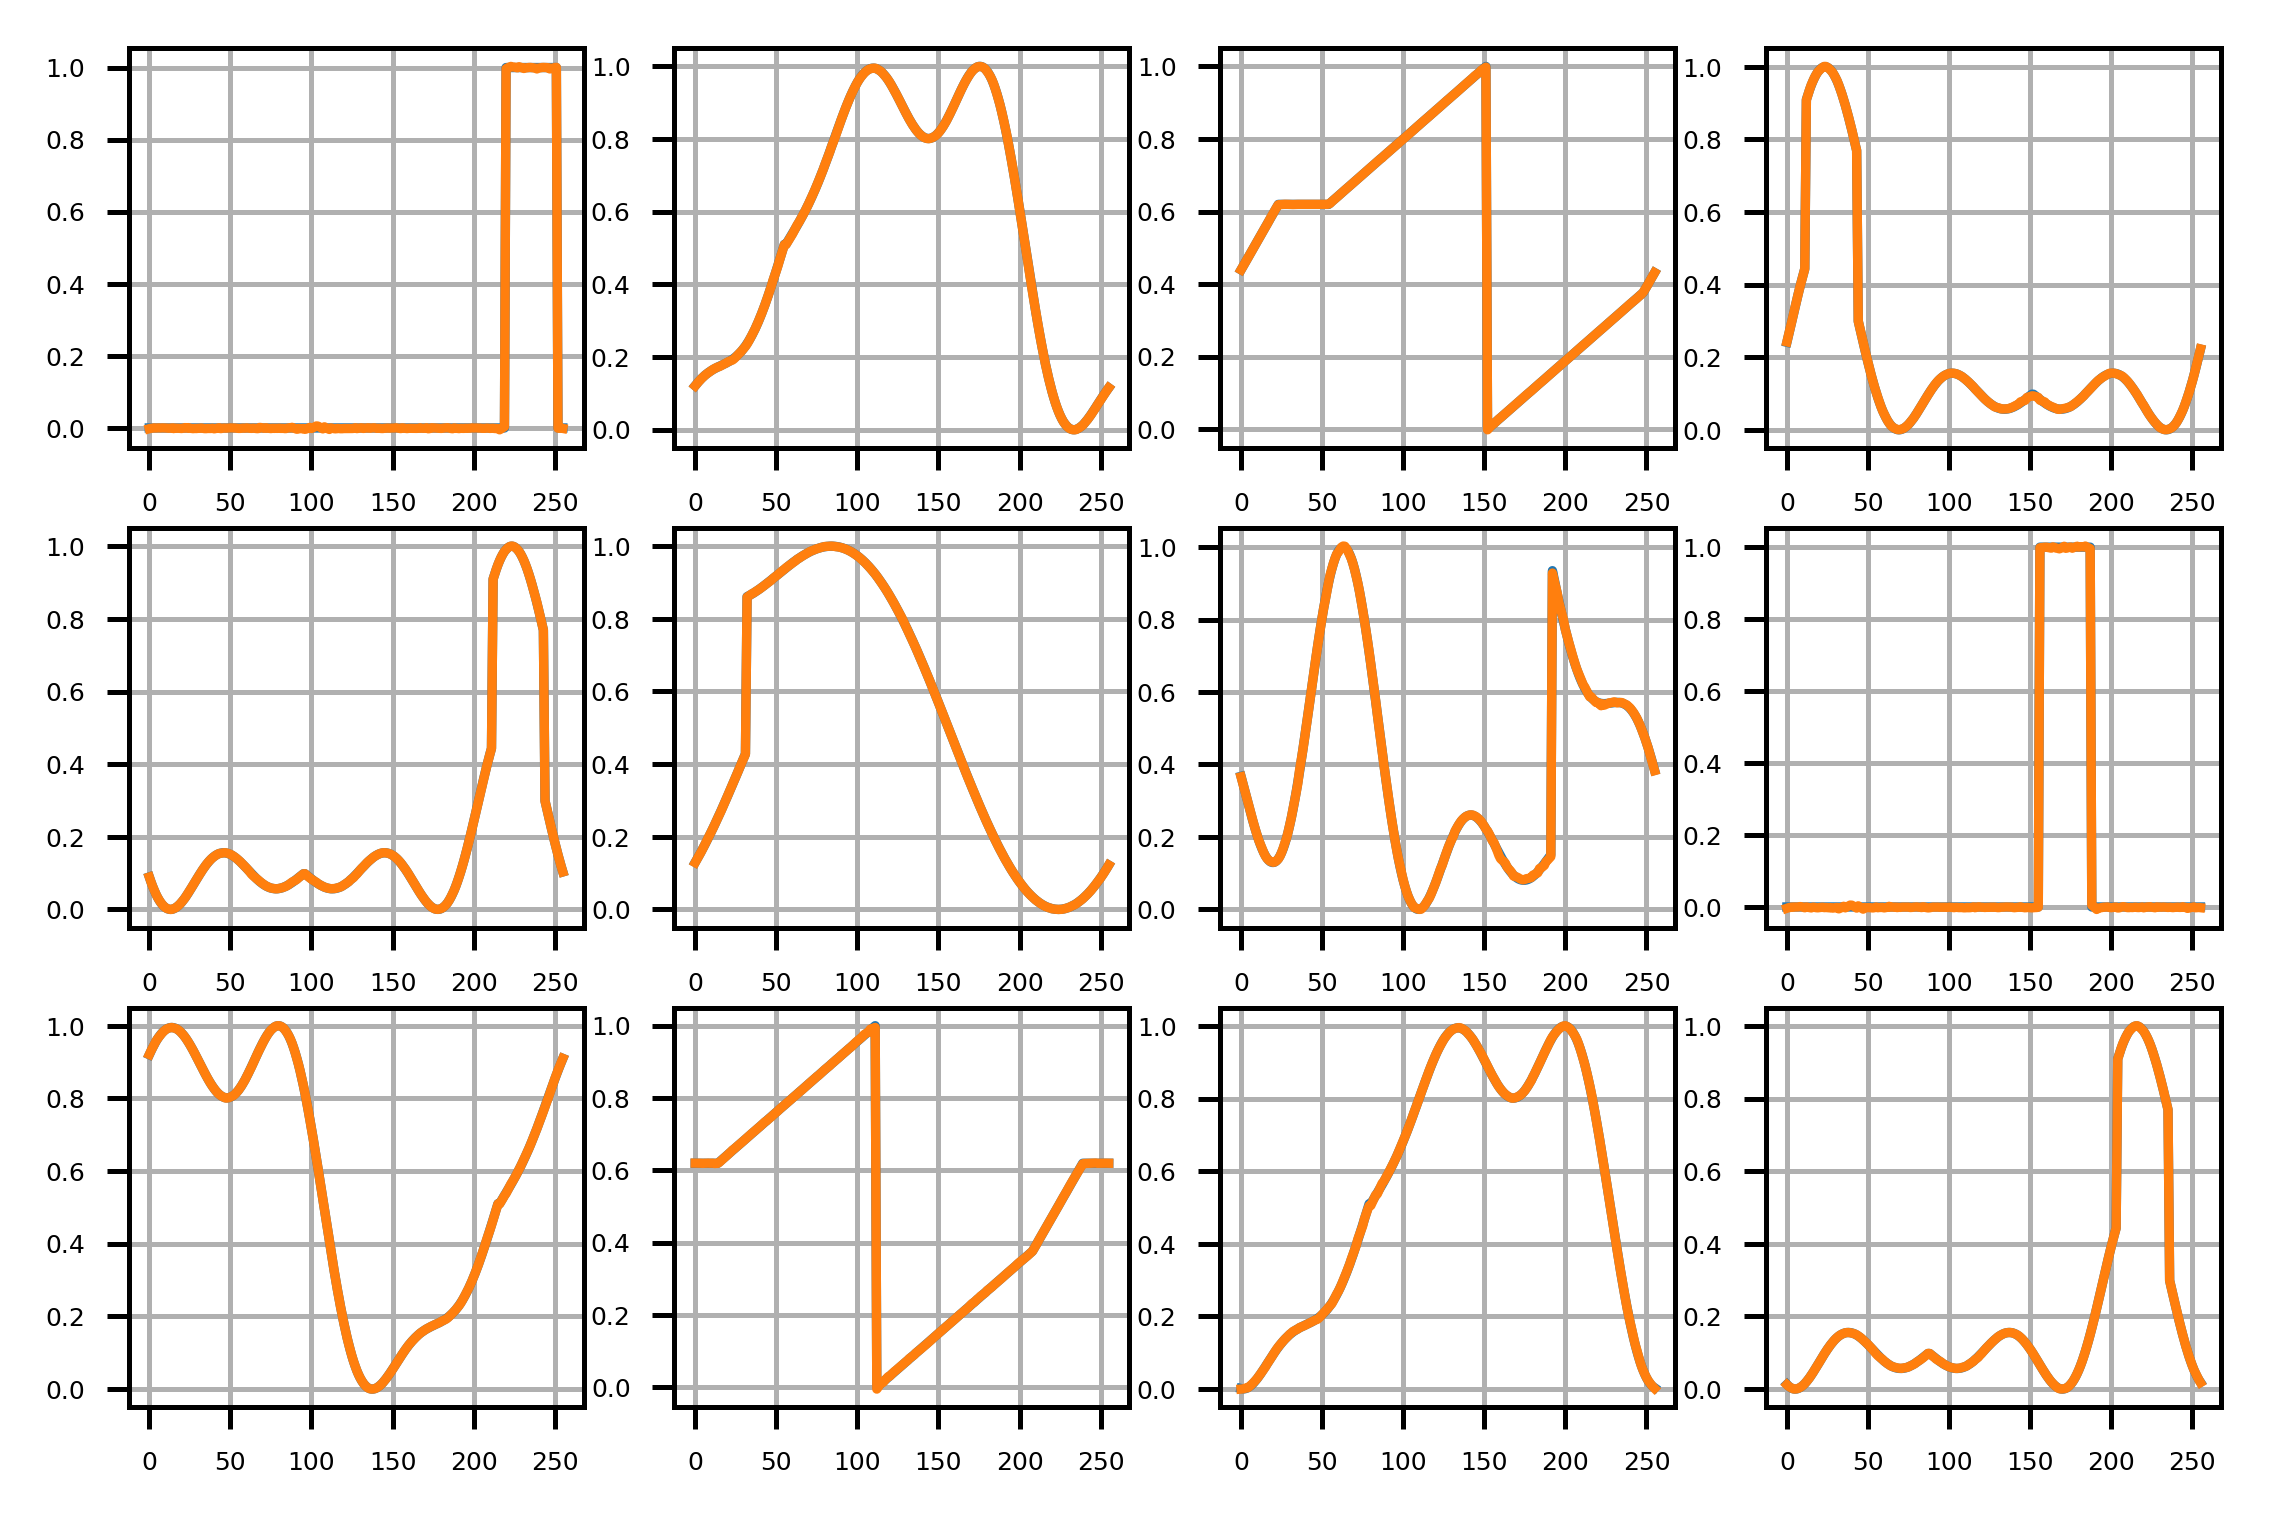

In [6]:
# Evaluate the test set
pred = model.predict(fft_signals_test_split)

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(signals_test[counter])
        col.plot(pred[counter])
        col.grid()
        counter+=1
plt.show()

## Absolute Error

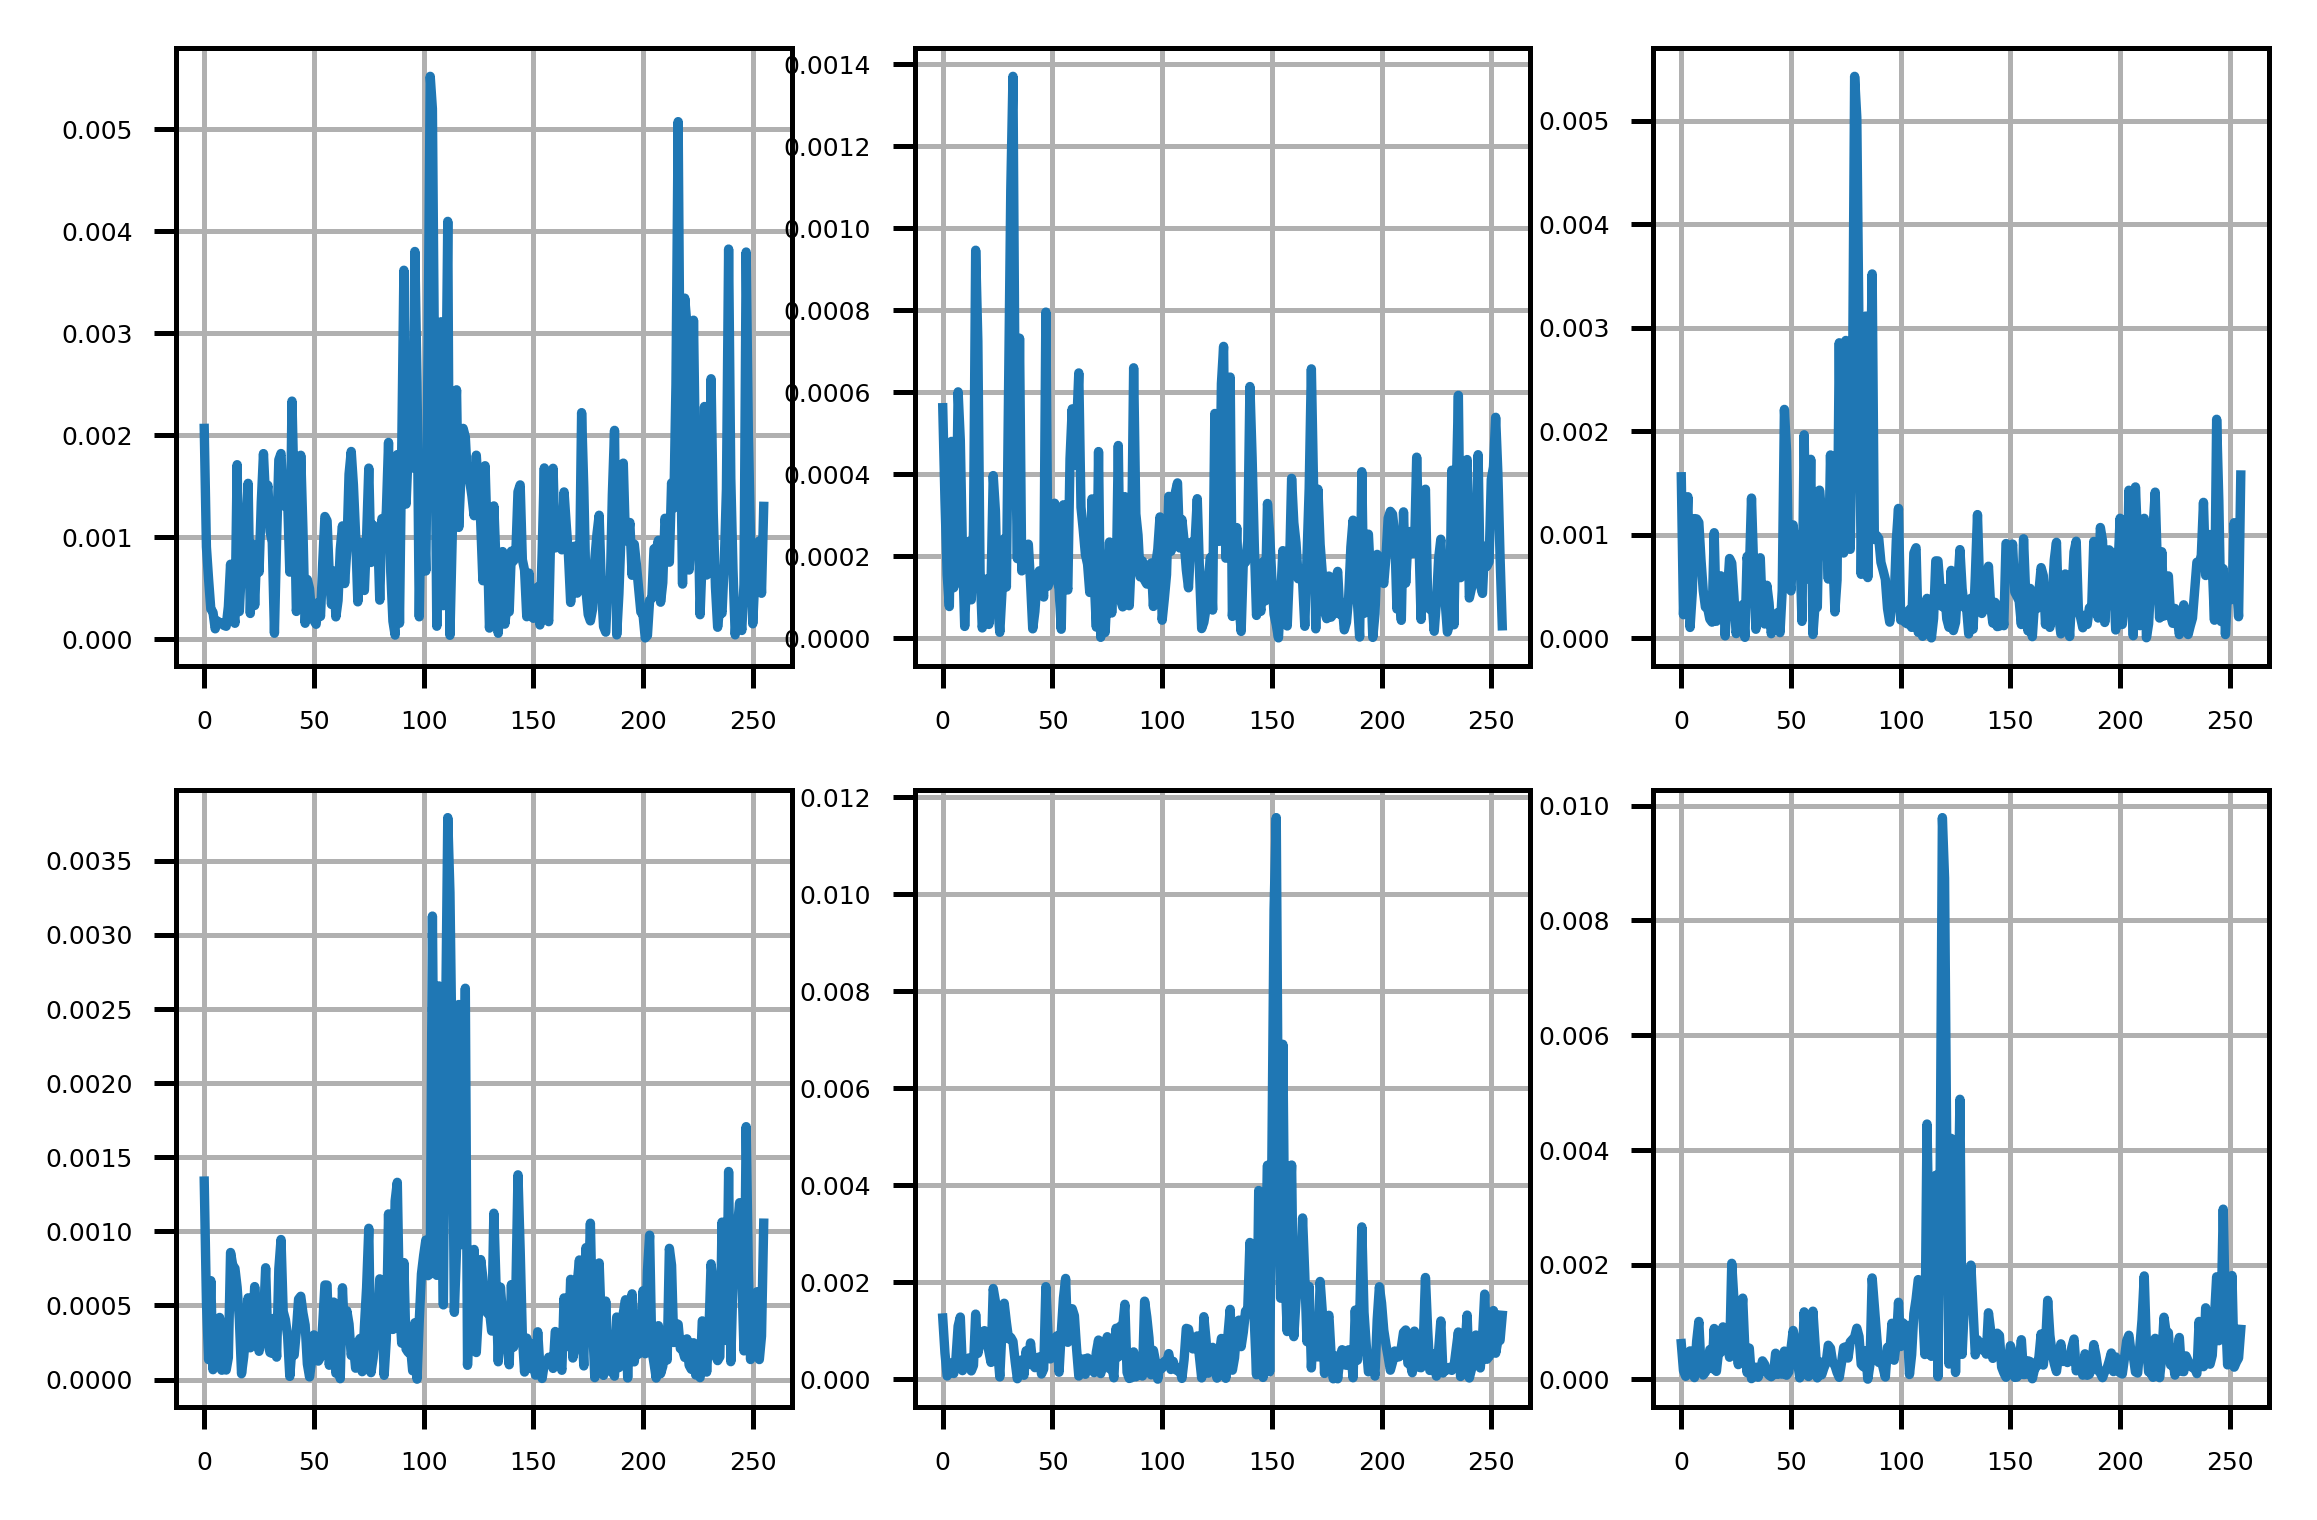

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(np.abs(signals_test[counter]-pred[counter,:256]))
        col.grid()
        counter+=5
plt.show()